# Suryakumar Selvakumar

## Title: Addressing Bias in Recruitment Algorithms

## Problem Statement:
More and more companies are turning to recruitment algorithms to make the hiring process smoother. These algorithms review resumes, media profiles, and other personal information to assess and prioritize job applicants. However, there is a rising worry, about the fairness and issues linked to these systems. The use of recruitment algorithms can unintentionally uphold biases found in the data resulting in discrimination against certain demographics. I felt that its necessary to make a fairer version of these hiring tools. This project aims to detect and mitigate biases in hiring tools created with several different AI models such as a Bi-Directional LSTM, a Random Forest Classifier and a Deep Neural Network.

# Code Implementation

In [1]:
import os
import io
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Concatenate, Dense, Embedding, LSTM, Bidirectional, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import svm, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

MAX_WORDS = 20000
NUM_EPOCHS = 16
NUM_EPOCHS_DEMO = 100
BATCH_SIZE = 128
NUM_OCC = 10

In [2]:
import tensorflow as tf

# Configure GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true to avoid GPU memory allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def loadBios(data_path, bios_file):
    """
    Function to load bios data.
    
    Parameters:
    data_path (str): Path to the data directory.
    bios_file (str): Name of the file containing bios data.
    
    Returns:
    tuple: Contains multiple arrays/dictionaries with bios data.
    """
    bios_data = np.load(os.path.join(data_path, bios_file), allow_pickle=True).item()
    
    # Assuming the bios_data contains specific keys. Adjust as necessary.
    bios_train = bios_data['Bios Train']
    bios_test = bios_data['Bios Test']
    profiles_train = bios_data['Profiles Train']
    profiles_test = bios_data['Profiles Test']
    labels_dict = bios_data['Labels Dict']

    return bios_train, bios_test, profiles_train, profiles_test, labels_dict

In [4]:
def generate_bios_file(data_path, database_file):
    # Load the dataset
    fairCV = np.load(os.path.join(data_path, database_file), allow_pickle=True).item()
    
    # Extract the bios data
    bios_data = {
        'Bios Train': fairCV['Bios Train'],
        'Bios Test': fairCV['Bios Test'],
        'Profiles Train': fairCV['Profiles Train'],
        'Profiles Test': fairCV['Profiles Test'],
        'Labels Dict': {
            'Blind Labels Train': fairCV['Blind Labels Train'],
            'Blind Labels Test': fairCV['Blind Labels Test'],
            'Biased Labels Train (Gender)': fairCV['Biased Labels Train (Gender)'],
            'Biased Labels Test (Gender)': fairCV['Biased Labels Test (Gender)'],
            'Biased Labels Train (Ethnicity)': fairCV['Biased Labels Train (Ethnicity)'],
            'Biased Labels Test (Ethnicity)': fairCV['Biased Labels Test (Ethnicity)']
        }
    }
    
    # Save the bios data to a file
    output_file = 'bios_data.npy'
    output_file_path = os.path.join(data_path, output_file)
    np.save(output_file_path, bios_data, allow_pickle=True)
    
    # Return the path to the output file
    return output_file_path

In [5]:
#Load the FairCV dataset based on the experiment configuration
def loadDataset(data_path, database_file, config = 'neutral'):
    
    fairCV = np.load(os.path.join(data_path, database_file), allow_pickle = True).item()
    profiles_train = fairCV['Profiles Train']
    profiles_test = fairCV['Profiles Test']
    
    if config == 'neutral':
        labels_train = fairCV['Blind Labels Train']
        labels_test = fairCV['Blind Labels Test']
        labels_train = np.expand_dims(labels_train, axis = 1)
        labels_test = np.expand_dims(labels_test, axis = 1)
        demo_labels_train = profiles_train[:,0:2]
        demo_labels_test = profiles_test[:,0:2]
        
        labels_train = np.concatenate((labels_train, demo_labels_train), axis = 1)
        labels_test = np.concatenate((labels_test, demo_labels_test), axis = 1)
        
        profiles_train = profiles_train[:,4:31]
        profiles_test = profiles_test[:,4:31]
        
        bios_train = fairCV['Bios Train'][:,0]
        bios_test = fairCV['Bios Test'][:,0]
        
    elif config == 'gender':
        labels_train = np.expand_dims(fairCV['Biased Labels Train (Gender)'], axis = 1)
        labels_test = np.expand_dims(fairCV['Biased Labels Test (Gender)'], axis = 1)
        gender_labels_train = np.expand_dims(profiles_train[:,1], axis = 1)
        gender_labels_test = np.expand_dims(profiles_test[:,1], axis = 1)
        
        labels_train = np.concatenate((labels_train, gender_labels_train), axis = 1)
        labels_test = np.concatenate((labels_test, gender_labels_test), axis = 1)
        
        profiles_train = profiles_train[:,4:31]
        profiles_test = profiles_test[:,4:31]
        
        bios_train = fairCV['Bios Train'][:,0]
        bios_test = fairCV['Bios Test'][:,0]
        
    elif config == 'ethnicity':
        labels_train = np.expand_dims(fairCV['Biased Labels Train (Ethnicity)'], axis = 1)
        labels_test = np.expand_dims(fairCV['Biased Labels Test (Ethnicity)'], axis = 1)
        ethnicity_labels_train = np.expand_dims(profiles_train[:,0], axis = 1)
        ethnicity_labels_test = np.expand_dims(profiles_test[:,0], axis = 1)
        
        labels_train = np.concatenate((labels_train, ethnicity_labels_train), axis = 1)
        labels_test = np.concatenate((labels_test, ethnicity_labels_test), axis = 1)
        
        profiles_train = profiles_train[:,4:31]
        profiles_test = profiles_test[:,4:31]
        
        bios_train = fairCV['Bios Train'][:,0]
        bios_test = fairCV['Bios Test'][:,0]
        
    elif config == 'evaluation':
        labels_train_blind = np.expand_dims(fairCV['Blind Labels Train'], axis = 1)
        labels_test_blind = np.expand_dims(fairCV['Blind Labels Test'], axis = 1)
        labels_train_gender = np.expand_dims(fairCV['Biased Labels Train (Gender)'], axis = 1)
        labels_test_gender = np.expand_dims(fairCV['Biased Labels Test (Gender)'], axis = 1)
        labels_train_ethnicity = np.expand_dims(fairCV['Biased Labels Train (Ethnicity)'], axis = 1)
        labels_test_ethnicity = np.expand_dims(fairCV['Biased Labels Test (Ethnicity)'], axis = 1)
        labels_train = np.concatenate((labels_train_blind, labels_train_gender,
                                       labels_train_ethnicity), axis = 1)
        labels_test = np.concatenate((labels_test_blind, labels_test_gender,
                                       labels_test_ethnicity), axis = 1)
        
        profiles_train = profiles_train[:,:11]
        profiles_test = profiles_test[:,:11]
        
        bios_train = fairCV['Bios Train'][:,0]
        bios_test = fairCV['Bios Test'][:,0]
        
    return labels_train, labels_test, profiles_train, profiles_test, bios_train, bios_test

In [6]:
# Process bios and return tokenized sequences
def processBios(bios_raw, t = None, max_len = 0):
    
    if t:
        sequences = t.texts_to_sequences(bios_raw)
        bios = pad_sequences(sequences, maxlen = max_len)
        
    else:
        t = Tokenizer(num_words = MAX_WORDS)
        t.fit_on_texts(bios_raw)
        sequences = t.texts_to_sequences(bios_raw)
        bios = pad_sequences(sequences)
    
    return bios, t, bios.shape[1]

In [7]:
# Load the fastText word embeddings
def load_vectors(fname):
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:], dtype ='float32')
        
    return d, data

In [8]:
# Define the network
def baseNetwork(num_feat, max_len_bios, data_path, word_emb_file, t):
    
    # Load the word embeddings
    embedding_dim, word_embeddings = load_vectors(os.path.join(data_path, word_emb_file))
    
    # Definie the embedding matrix
    embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))
    
    for word, i in t.word_index.items():
        if i < MAX_WORDS:
            embedding_vector = word_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    del word_embeddings
    
    #Define the recurrent network
    text_input = Input(shape = (max_len_bios,))
    embedding = Embedding(MAX_WORDS, embedding_dim, input_length = max_len_bios,
                          weights = [embedding_matrix], trainable = False)(text_input)
    text_embedding = Bidirectional(LSTM(32, activation = 'tanh'))(embedding)
    
    #Define the feature network and merge the two networks
    feature_input = Input(shape = (num_feat,))
    concat = Concatenate()([feature_input, text_embedding])
    x = Dense(40, activation = 'relu', input_shape = (concat.shape),
              name = 'embedding_layer')(concat)
    x = Dropout(0.3)(x)
    x = Dense(20, activation = 'relu')(x)
    output = Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs = [feature_input, text_input], outputs = output)
    model.summary()
    # keras.utils.plot_model(model, "FairCVtest_Architecture.png", show_shapes = False)
    
    return model

In [9]:
#Train the hiring tool
def trainHiringTool(model, profiles_train, bios_train, labels_train):
    
    model.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.MeanAbsoluteError())
    
    history = model.fit([profiles_train, bios_train], labels_train, batch_size = BATCH_SIZE,
                        epochs = NUM_EPOCHS)
    
    print('##########TRAINING##########')
    print('Training loss (MAE): {:.3f}'.format(history.history['loss'][-1]))
    
    return model, history

In [10]:
# Evaluate the hiring tool
def evaluateHiringTool(model, profiles_test, bios_test, labels_test):
    
    scores_loss = model.evaluate([profiles_test, bios_test], labels_test)
    
    print('##########EVALUATION##########')
    print('Test loss (MAE): {:.3f}'.format(scores_loss))
    
    scores = model.predict([profiles_test, bios_test])
    
    return scores

In [11]:
# Save the results
def saveResults(data_path, config, model, t, history, scores, max_len):
    
    fairCVtest_results = {}
    fairCVtest_results['History'] = history.history['loss']
    fairCVtest_results['Scores'] = scores
    fairCVtest_results['Len Bios'] = max_len
    
    save_file =  'FairCVtest ' + config + '.npy'
    np.save(os.path.join(data_path, save_file), fairCVtest_results, allow_pickle = True)
    
    model_file = 'HiringTool ' + config + '.h5'
    model.save(os.path.join(data_path, model_file))
    
    tokenizer_file = 'Tokenizer ' + config + '.pickle'
    with open(os.path.join(data_path, tokenizer_file), 'wb') as handle:
        pickle.dump(t, handle, protocol = pickle.HIGHEST_PROTOCOL)
        
    #with open(path, 'rb') as handle:
        #t = pickle.load(handle)

In [12]:
# Compute the KL divergence
def kl_divergence(p, q):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.sum(np.where(np.logical_and(p > 0, q > 0), p * np.log(p / q), 0))

    # The KL divergence is defined if P and Q are normalized and Q!=0 where P !=0

In [13]:
# Compute distributions from the raw scores, and return the KL divergence
def computeKL(x,y):
    
    p = []
    q = []
    
    # Compute scores distributions
    for i in range(0,98,2):
        i = i/100
        j = i + 0.02
        p.append(np.sum(np.where(np.logical_and(x >= i, x <j), 1, 0)))
        q.append(np.sum(np.where(np.logical_and(y >= i, y <j), 1, 0)))
        
    p = np.asarray(p).reshape(1,-1)
    q = np.asarray(q).reshape(1,-1)
    
    # Normalize distributions
    p = p/x.shape[0]
    q = q/y.shape[0]
    
    return kl_divergence(p,q)

In [14]:
#Generate feature embeddings from the profiles
def generateCVEmbeddings(config, profiles_train, profiles_test, bios_train, bios_test):
    
    model_file = 'HiringTool ' + config + '.h5'
    model = keras.models.load_model(model_file)
    
    embedding = model.get_layer('embedding_layer').output
    embedding = Flatten(name = 'Flatten')(embedding)
    feature_extractor = keras.Model(inputs = model.input, outputs = embedding)
    
    embeddings_train = feature_extractor.predict([profiles_train, bios_train])
    embeddings_test = feature_extractor.predict([profiles_test, bios_test])
    
    embeddings_train = preprocessing.normalize(embeddings_train, norm = 'l2', axis = 1,
                                               copy = True, return_norm = False)
    embeddings_test = preprocessing.normalize(embeddings_test, norm = 'l2', axis = 1,
                                               copy = True, return_norm = False)
    
    return embeddings_train, embeddings_test

In [15]:
def evaluateSVM(embeddings_train, embeddings_test, labels_train, labels_test):
    
    svm_clf = svm.SVC(probability = True, kernel = 'rbf')
    svm_clf.fit(embeddings_train, labels_train)
    
    y_pred_svm = svm_clf.predict(embeddings_test)
    acc_svm = accuracy_score(labels_test, y_pred_svm)
    print('SVM (rbf kernel) Accuracy: {:.4f}'.format(acc_svm))

In [16]:
def evaluateRandomForest(embeddings_train, embeddings_test, labels_train, labels_test):
    
    rf_clf = RandomForestClassifier(max_depth = 1000, random_state = 0)
    rf_clf.fit(embeddings_train, labels_train)
    
    y_pred_rf = rf_clf.predict(embeddings_test)
    acc_rf = accuracy_score(labels_test, y_pred_rf)
    print('RF Acc: {:.4f}'.format(acc_rf))

In [17]:
def evaluateNeuralNetwork(embeddings_train, embeddings_test, labels_train, labels_test, config):
    
    labels_train = keras.utils.to_categorical(labels_train)
    labels_test = keras.utils.to_categorical(labels_test)
    
    # Define neural network
    embedding_input = Input(shape=(embeddings_train.shape[1],))
    x = Dense(128, activation='relu', name='embedding_layer')(embedding_input)  # Adjust size as needed
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(labels_train.shape[1], activation='softmax')(x)
        
    nn_clf = keras.Model(inputs=embedding_input, outputs=x)

    nn_clf.compile(optimizer=keras.optimizers.Adam(),
                   loss=keras.losses.CategoricalCrossentropy(), metrics=['acc'])
        
    # Train and evaluate network
    callback = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
    
    nn_clf.fit(embeddings_train, labels_train, batch_size=BATCH_SIZE,
               epochs=NUM_EPOCHS_DEMO, callbacks=[callback],
               validation_data=(embeddings_test, labels_test))
    
    results_nn = nn_clf.evaluate(embeddings_test, labels_test, batch_size=BATCH_SIZE)
    
    print('Neural Network Acc: {:.4f}'.format(results_nn[1]))
    
    y_pred_nn = nn_clf.predict(embeddings_test)
    y_pred_nn_prob = y_pred_nn[:, 1]
    
    # Generate embeddings
    embedding = nn_clf.get_layer('embedding_layer').output
    feature_extractor = keras.Model(inputs=nn_clf.input, outputs=embedding)
    
    embeddings = feature_extractor.predict(embeddings_test)
    embeddings = preprocessing.normalize(embeddings, norm='l2', axis=1, copy=True, return_norm=False)
    
    return embeddings, y_pred_nn_prob

In [18]:
def representTSNE(data_path, embeddings, labels, config):
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
    tsne_transf = tsne.fit_transform(embeddings)
    
    save_file = 'tsne ' + config + '.png'
    
    plt.figure(figsize=(7.3, 7.3))
    ax = plt.axes()
    ax.set_facecolor('white')
    
    if config in ['ethnicity', 'agnostic ethnicity', 'neutral']:
        E1 = (labels == 0)
        E2 = (labels == 1)
        E3 = (labels == 2)
        
        plt.scatter(tsne_transf[E1, 0], tsne_transf[E1, 1], color='y', alpha=.3, lw=2.5, s=50, label='Group 1')
        plt.scatter(tsne_transf[E2, 0], tsne_transf[E2, 1], color='g', alpha=.3, lw=2.5, s=50, label='Group 2')
        plt.scatter(tsne_transf[E3, 0], tsne_transf[E3, 1], color='b', alpha=.3, lw=2.5, s=50, label='Group 3')
        plt.title('t-SNE representation by Ethnicity')
    else:
        male = (labels == 0)
        female = (labels == 1)
        
        plt.scatter(tsne_transf[male, 0], tsne_transf[male, 1], color='r', alpha=.3, lw=2.5, s=50, label='Male')
        plt.scatter(tsne_transf[female, 0], tsne_transf[female, 1], color='c', alpha=.3, lw=2.5, s=50, label='Female')
        plt.title('t-SNE representation by Gender')
    
    plt.legend(loc='upper right')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()


In [19]:
def evaluateDemographics(data_path, database_file, config):
    
    keras.backend.clear_session()
    os.chdir(data_path)
    
    labels_train, labels_test, profiles_train, profiles_test, bios_train, bios_test = loadDataset(data_path, database_file, config)
    demo_labels_train = labels_train[:,1]
    demo_labels_test = labels_test[:,1]
    
    tokenizer_file = 'Tokenizer ' + config + '.pickle'
    with open(tokenizer_file, 'rb') as f:
        t = pickle.load(f)
    
    results_file = 'FairCVtest ' + config + '.npy'
    results = np.load(results_file, allow_pickle=True).item()
    max_len = results['Len Bios']
    
    bios_train, _, _ = processBios(bios_train, t, max_len)
    bios_test, _, _ = processBios(bios_test, t, max_len)
    
    embeddings_train, embeddings_test = generateCVEmbeddings(config, profiles_train, profiles_test, bios_train, bios_test)
    
    # Evaluate SVM
    evaluateSVM(embeddings_train, embeddings_test, demo_labels_train, demo_labels_test)
    
    # Evaluate RF
    evaluateRandomForest(embeddings_train, embeddings_test, demo_labels_train, demo_labels_test)
    
    # Evaluate NN
    embeddings, y_pred_nn_prob = evaluateNeuralNetwork(embeddings_train, embeddings_test, demo_labels_train, demo_labels_test, config)
    
    # t-SNE representation
    representTSNE(data_path, embeddings, demo_labels_test, config)
    
    # The neutral case has two options, gender and ethnicity
    if config == 'neutral':
        
        demo_labels_train = labels_train[:,2]
        demo_labels_test = labels_test[:,2]
        
        # Evaluate SVM
        evaluateSVM(embeddings_train, embeddings_test, demo_labels_train, demo_labels_test)
        
        # Evaluate RF
        evaluateRandomForest(embeddings_train, embeddings_test, demo_labels_train, demo_labels_test)
        
        # Evaluate NN
        embeddings, y_pred_nn_prob = evaluateNeuralNetwork(embeddings_train, embeddings_test, demo_labels_train, demo_labels_test, config)
        
        representTSNE(data_path, embeddings, demo_labels_test, 'neutral gender')


In [20]:
# Test demographic parity by computing p value in the top 1000 candidates.
def testDemographicParity(scores, demo_att, config):
    
    scores_sorted = np.argsort(scores, axis = 0)
    scores_sorted = scores_sorted[::-1]
    
    demo_att_sorted = demo_att[scores_sorted]
    top1000 = demo_att_sorted[:1000]
    
    if config in ['gender', 'agnostic gender','neutral gender']:
        top1000_female = np.sum(top1000)/1000
        top1000_male = 1 - top1000_female
        
        p_val = min(top1000_female/top1000_male, top1000_male/top1000_female)
        print('P-% Value: {:.2f}%'.format(p_val*100))
    
    elif config in ['ethnicity', 'agnostic ethnicity','neutral ethnicity']:
        top1000_g2 = np.sum(top1000 % 2)/1000
        top1000_g3 = np.sum(top1000//2)/1000
        top1000_g1 = 1 - top1000_g2 - top1000_g3
        
        p_val_1 = min(top1000_g2/top1000_g1,top1000_g1/top1000_g2)
        p_val_2 = min(top1000_g3/top1000_g1,top1000_g1/top1000_g3)
        p_val_3 = min(top1000_g3/top1000_g2,top1000_g2/top1000_g3)
        
        print('P-% Value (G2/G1): {:.2f}%'.format(p_val_1*100))
        print('P-% Value (G3/G1): {:.2f}%'.format(p_val_2*100))
        print('P-% Value (G3/G2): {:.2f}%'.format(p_val_3*100))

In [21]:
def computeTopScore(scores, demo_att, config):
    
    scores_sorted = np.argsort(scores, axis = 0)
    scores_sorted = scores_sorted[::-1]
    
    demo_att_sorted = demo_att[scores_sorted]
    top100 = demo_att_sorted[:1000]
      
    if config in ['gender', 'agnostic gender', 'neutral gender']:
        top100_female = np.sum(top100)/1000
        top100_male = 1 - top100_female
        
        print('Top 100 Male: {:.2f}%'.format(top100_male * 100))
        print('Top 100 Female: {:.2f}%'.format(top100_female * 100))
         
    elif config in ['ethnicity', 'agnostic ethnicity', 'neutral ethnicity']:
        top100_g2 = np.sum(top100 % 2)/1000
        top100_g3 = np.sum(top100//2)/1000
        top100_g1 = 1 - top100_g2 - top100_g3

        print('Top 100 G1: {:.2f}%'.format(top100_g1*100))
        print('Top 100 G2: {:.2f}%'.format(top100_g2*100))
        print('Top 100 G3: {:.2f}%'.format(top100_g3*100))

In [22]:
def testEqualityOfOpportunity(scores, demo_att, blind_labels, blind_labels_test, config, p = 75):
    
    threshold = np.percentile(blind_labels, p)
    
    blind_labels_test[blind_labels_test < threshold] = 0
    blind_labels_test[blind_labels_test >= threshold] = 1
    scores[scores < threshold] = 0
    scores[scores > threshold] = 1
    
    if config in ['gender', 'agnostic gender', 'neutral gender']:
        male = (demo_att == 0)
        female = (demo_att == 1)
        
        labels_male = (blind_labels_test[male] == 1)
        labels_female = (blind_labels_test[female] == 1)
        scores_male = scores[male]
        scores_female = scores[female]
        
        tpr_male = np.sum(scores_male[labels_male])/np.sum(labels_male)
        tpr_female = np.sum(scores_female[labels_female])/np.sum(labels_female)
    
        print('TPR Male: {:.2f}%'.format(tpr_male * 100))
        print('TPR Female: {:.2f}%'.format(tpr_female * 100))
        print('TPR Difference: {:.2f}%'.format((tpr_male - tpr_female)*100))
        
    elif config in ['ethnicity', 'agnostic ethnicity', 'neutral ethnicity']:
        G1 = (demo_att == 0)
        G2 = (demo_att == 1)
        G3 = (demo_att == 2)
        
        labels_g1 = (blind_labels_test[G1] == 1)
        labels_g2 = (blind_labels_test[G2] == 1)
        labels_g3 = (blind_labels_test[G3] == 1)
        scores_g1 = scores[G1]
        scores_g2 = scores[G2]
        scores_g3 = scores[G3]
        
        tpr_g1 = np.sum(scores_g1[labels_g1])/np.sum(labels_g1)
        tpr_g2 = np.sum(scores_g2[labels_g2])/np.sum(labels_g2)
        tpr_g3 = np.sum(scores_g3[labels_g3])/np.sum(labels_g3)
        
        print('TPR G1: {:.2f}%'.format(tpr_g1 * 100))
        print('TPR G2: {:.2f}%'.format(tpr_g2 * 100))
        print('TPR G3: {:.2f}%'.format(tpr_g3 * 100))
        print('TPR Difference(G1-G2): {:.2f}%'.format((tpr_g1 - tpr_g2)*100))
        print('TPR Difference(G1-G3): {:.2f}%'.format((tpr_g1 - tpr_g3)*100))
        print('TPR Difference(G2-G3): {:.2f}%'.format((tpr_g2 - tpr_g3)*100))

In [23]:
#Function to compute bias evaluation metrics

def computeBiasMetrics(scores, labels_train, labels_test, gender_labels, ethnicity_labels, config):
    print(f"Computing Bias Metrics for configuration: {config}")
    print("\n")
    
    if config in ['gender', 'agnostic gender']:
        computeTopScore(scores, gender_labels, config)
        testDemographicParity(scores, gender_labels, config)
        testEqualityOfOpportunity(scores, gender_labels, labels_train[:,0], labels_test[:,0], config)
        print("\n")
        
    elif config in ['ethnicity', 'agnostic ethnicity']:
        computeTopScore(scores, ethnicity_labels, config)
        testDemographicParity(scores, ethnicity_labels, config)
        testEqualityOfOpportunity(scores, ethnicity_labels, labels_train[:,0], labels_test[:,0], config)
        print("\n")
        
    elif config == 'neutral':
        # Gender
        print("Gender:")
        computeTopScore(scores, gender_labels, 'neutral gender')
        testDemographicParity(scores, gender_labels, 'neutral gender')
        testEqualityOfOpportunity(scores, gender_labels, labels_train[:,0], labels_test[:,0], 'neutral gender')
        print("\n")
        # Ethnicity
        print("Ethnicity:")
        computeTopScore(scores, ethnicity_labels, 'neutral ethnicity')
        testDemographicParity(scores, ethnicity_labels, 'neutral ethnicity')
        testEqualityOfOpportunity(scores, ethnicity_labels, labels_train[:,0], labels_test[:,0], 'neutral ethnicity')
        print("\n")

In [24]:
def analyzeResults(data_path, database_file, config = 'neutral'):
    
    results_file = 'FairCVtest ' + config + '.npy'
    results = np.load(os.path.join(data_path, results_file), allow_pickle = True).item()
    scores = results['Scores']
    
    labels_train, labels_test, _, profiles_test, _, _ = loadDataset(data_path, database_file, config = 'evaluation')
    
    ethnicity_labels = profiles_test[:,0]
    gender_labels = profiles_test[:,1]
    suitability_labels = profiles_test[:,3]
    
    # Gender distributions
    save_file = 'Gender distribution ' + config + '.png'
    
    male = (gender_labels == 0)
    female = (gender_labels == 1)
    
    KL = computeKL(scores[male], scores[female])
        
    plt.figure(figsize = (7.3,5.2))
    ax = plt.axes()
    ax.set_facecolor('white')
    

    plt.title('Hiring Results by Gender, KL(P||Q) = {:.3f}'.format(KL))
    sns.distplot(scores[male], hist = False, kde_kws = {'shade' : True}, color = 'r', label = 'Male')
    sns.distplot(scores[female], hist = False, kde_kws = {'shade' : True}, color = 'c', label = 'Female')
    plt.legend(loc='upper right')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True,  linestyle=':',color = 'lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi = 1000)
    plt.show()
    
    # Ethnicity distributions
    save_file = 'Ethnicity distributions ' + config + '.png'
    
    E1 = (ethnicity_labels == 0)
    E2 = (ethnicity_labels == 1)
    E3 = (ethnicity_labels == 2)
    
    KL1 = computeKL(scores[E1], scores[E2])
    KL2 = computeKL(scores[E1], scores[E3])
    KL3 = computeKL(scores[E2], scores[E3])
    KL = (KL1 + KL2 + KL3)/3
            
    plt.figure(figsize = (7.3,5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Hiring Results by Ethnicity, KL(P||Q) = {:.3f}'.format(KL))
    sns.distplot(scores[E1], hist = False, kde_kws = {'shade' : True}, color = 'y', label = 'Group 1')
    sns.distplot(scores[E2], hist = False, kde_kws = {'shade' : True}, color = 'g', label = 'Group 2')
    sns.distplot(scores[E3], hist = False, kde_kws = {'shade' : True}, color = 'b', label = 'Group 3')
    plt.legend(loc='upper right')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True,  linestyle=':',color = 'lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi = 1000)
    plt.show()
    
    # Occupation distributions
    save_file = 'Occupation distributions ' + config + '.png'
    
    O1 = (suitability_labels == 0.25)
    O2 = (suitability_labels == 0.5)
    O3 = (suitability_labels == 0.75)
    O4 = (suitability_labels == 1)
            
    plt.figure(figsize = (7.3,5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Hiring Results by Occupation Group')
    sns.distplot(scores[O1], hist = False, kde_kws = {'shade' : True}, color = 'r', label = 'AV') 
    sns.distplot(scores[O2], hist = False, kde_kws = {'shade' : True}, color = 'g', label = 'JA')
    sns.distplot(scores[O3], hist = False, kde_kws = {'shade' : True}, color = 'b', label = 'HC')
    sns.distplot(scores[O4], hist = False, kde_kws = {'shade' : True}, color = 'y', label = 'EN')
    plt.legend(loc='upper right')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True,  linestyle=':',color = 'lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi = 1000)
    plt.show()
    
    # Compute and print bias metrics
    computeBiasMetrics(scores, labels_train, labels_test, gender_labels, ethnicity_labels, config)

In [25]:
def analyzeDatabase(data_path, database_file, bios_file):
    
    labels_train, _, profiles_train, profiles_test, _, _ = loadDataset(data_path, database_file, config = 'evaluation')
    
    ethnicity_labels_train = profiles_train[:,0]
    gender_labels_train = profiles_train[:,1]
    occupation_labels_train = profiles_train[:,2]
    suitability_labels = profiles_train[:,3]
    
    ethnicity_labels_test = profiles_test[:,0]
    gender_labels_test = profiles_test[:,1]
    occupation_labels_test = profiles_test[:,2]
    
    _,_,_,_, labels_dict = loadBios(data_path, bios_file)
    labels_text = list(labels_dict.values())
    
    ######### Gender ###########
    
    num_females = sum(gender_labels_train)/gender_labels_train.shape[0] * 100
    num_males = 100 - num_females
    
    print('Percentage of males in training set = {:.2f}%'.format(num_males))
    print('Percentage of females in training set = {:.2f}% \n'.format(num_females))
    
    num_females_test = sum(gender_labels_test)/gender_labels_test.shape[0] * 100
    num_males_test = 100 - num_females_test
    
    print('Percentage of males in test set = {:.2f}%'.format(num_males_test))
    print('Percentage of females in test set = {:.2f}% \n'.format(num_females_test))
    
    male = (gender_labels_train == 0)
    female = (gender_labels_train == 1)
    
    # Blind labels
    KL = computeKL(labels_train[male, 0], labels_train[female, 0])

    save_file = 'Blind Labels Distribution by Gender (Training).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Blind Labels Distribution by Gender, KL(P||Q) = {:.3f}'.format(KL))
    sns.kdeplot(labels_train[male, 0], fill=True, color='r', label='Male')
    sns.kdeplot(labels_train[female, 0], fill=True, color='c', label='Female')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()
    
    # Biased labels
    KL = computeKL(labels_train[male, 1], labels_train[female, 1])

    save_file = 'Biased Labels Distribution by Gender (Training).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Biased Labels Distribution by Gender, KL(P||Q) = {:.3f}'.format(KL))
    sns.kdeplot(labels_train[male, 1], fill=True, color='r', label='Male')
    sns.kdeplot(labels_train[female, 1], fill=True, color='c', label='Female')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()

    
    ######### Ethnicity  ###########
    num_g2 = sum(ethnicity_labels_train % 2)/ethnicity_labels_train.shape[0] * 100
    num_g3 = sum(ethnicity_labels_train // 2)/ethnicity_labels_train.shape[0] * 100
    num_g1 = 100 - num_g2 - num_g3
    
    print('Percentage of G1 in training set = {:.2f}%'.format(num_g1))
    print('Percentage of G2 in training set = {:.2f}%'.format(num_g2))
    print('Percentage of G3 in training set = {:.2f}%\n'.format(num_g3))
    
    num_g2_test = sum(ethnicity_labels_test % 2)/ethnicity_labels_test.shape[0] * 100
    num_g3_test = sum(ethnicity_labels_test // 2)/ethnicity_labels_test.shape[0] * 100
    num_g1_test = 100 - num_g2_test - num_g3_test
    
    print('Percentage of G1 in test set = {:.2f}%'.format(num_g1_test))
    print('Percentage of G2 in test set = {:.2f}%'.format(num_g2_test))
    print('Percentage of G3 in test set = {:.2f}%\n'.format(num_g3_test))
    
    E1 = (ethnicity_labels_train == 0)
    E2 = (ethnicity_labels_train == 1)
    E3 = (ethnicity_labels_train == 2)
    
    # Blind labels
    KL1 = computeKL(labels_train[E1, 0], labels_train[E2, 0])
    KL2 = computeKL(labels_train[E1, 0], labels_train[E3, 0])
    KL3 = computeKL(labels_train[E2, 0], labels_train[E3, 0])
    KL = (KL1 + KL2 + KL3)/3

    save_file = 'Blind Labels Distribution by Ethnicity (Training).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Blind Labels Distribution by Ethnicity, KL(P||Q) = {:.3f}'.format(KL))
    sns.kdeplot(labels_train[E1, 0], fill=True, color='y', label='Group 1')
    sns.kdeplot(labels_train[E2, 0], fill=True, color='g', label='Group 2')
    sns.kdeplot(labels_train[E3, 0], fill=True, color='b', label='Group 3')
    plt.legend(loc='upper right')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()

    
    # Biased labels
    KL1 = computeKL(labels_train[E1, 2], labels_train[E2, 2])
    KL2 = computeKL(labels_train[E1, 2], labels_train[E3, 2])
    KL3 = computeKL(labels_train[E2, 2], labels_train[E3, 2])
    KL = (KL1 + KL2 + KL3)/3

    save_file = 'Biased Labels Distribution by Ethnicity (Training).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Biased Labels Distribution by Ethnicity, KL(P||Q) = {:.3f}'.format(KL))
    sns.kdeplot(labels_train[E1, 2], fill=True, color='y', label='Group 1')
    sns.kdeplot(labels_train[E2, 2], fill=True, color='g', label='Group 2')
    sns.kdeplot(labels_train[E3, 2], fill=True, color='b', label='Group 3')
    plt.legend(loc='upper right')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()

    
    ######## Occupation ###########
    
    # Occupation distribution train
    save_file = 'Occupation Distribution (Training).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Occupation Distribution in Training Set')
    sns.set(color_codes=True)
    g = sns.histplot(occupation_labels_train, kde=True, stat="density", bins=NUM_OCC, kde_kws={'cut': 0}, color='blue')
    g.set_xticks(np.arange(len(labels_text[:NUM_OCC])))
    g.set_xticklabels(labels_text[:NUM_OCC], rotation='vertical')
    plt.xlabel('Occupation')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()


    # Occupation distribution test
    save_file = 'Occupation Distribution (Test).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Occupation Distribution in Test Set')
    sns.set(color_codes=True)
    g = sns.histplot(occupation_labels_test, kde=True, stat="density", bins=NUM_OCC, kde_kws={'cut': 0}, color='blue')
    g.set_xticks(np.arange(len(labels_text[:NUM_OCC])))
    g.set_xticklabels(labels_text[:NUM_OCC], rotation='vertical')
    plt.xlabel('Occupation')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()


    O1 = (suitability_labels == 0.25)
    O2 = (suitability_labels == 0.5)
    O3 = (suitability_labels == 0.75)
    O4 = (suitability_labels == 1)

    # Blind labels
    save_file = 'Blind Labels Distribution by Occupation (Training).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Blind Labels by Occupation Group')
    sns.kdeplot(labels_train[O1, 0], shade=True, color='r', label='AV')
    sns.kdeplot(labels_train[O2, 0], shade=True, color='g', label='JA')
    sns.kdeplot(labels_train[O3, 0], shade=True, color='b', label='HC')
    sns.kdeplot(labels_train[O4, 0], shade=True, color='y', label='EN')
    plt.legend(loc='upper right')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()

    
    # Gender biased labels
    save_file = 'Gender Biased Labels Distribution by Occupation (Training).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Gender Biased Labels by Occupation Group')
    sns.kdeplot(labels_train[O1, 1], shade=True, color='r', label='AV')
    sns.kdeplot(labels_train[O2, 1], shade=True, color='g', label='JA')
    sns.kdeplot(labels_train[O3, 1], shade=True, color='b', label='HC')
    sns.kdeplot(labels_train[O4, 1], shade=True, color='y', label='EN')
    plt.legend(loc='upper right')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()

    
    # Ethnicity biased labels
    save_file = 'Ethnicity Biased Labels Distribution by Occupation (Training).png'

    plt.figure(figsize=(7.3, 5.2))
    ax = plt.axes()
    ax.set_facecolor('white')

    plt.title('Ethnicity Biased Labels by Occupation Group')
    sns.kdeplot(labels_train[O1, 2], shade=True, color='r', label='AV')
    sns.kdeplot(labels_train[O2, 2], shade=True, color='g', label='JA')
    sns.kdeplot(labels_train[O3, 2], shade=True, color='b', label='HC')
    sns.kdeplot(labels_train[O4, 2], shade=True, color='y', label='EN')
    plt.legend(loc='upper right')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', color='lightgrey')
    plt.savefig(os.path.join(image_path, save_file), dpi=1000)
    plt.show()

In [26]:
def fairCVtest(data_path, database_file, word_emb_file, config = 'neutral'):
    # Clear any existing TensorFlow session to free up GPU memory
    keras.backend.clear_session()
    
    labels_train, labels_test, profiles_train, profiles_test, bios_train, bios_test = loadDataset(data_path, database_file, config)
    labels_train = labels_train[:,0]
    labels_test = labels_test[:,0]
    
    bios_train, t, max_len = processBios(bios_train)
    bios_test, _, _ = processBios(bios_test, t, max_len)
    
    model = baseNetwork(profiles_train.shape[1], max_len, data_path, word_emb_file, t)
    model, history = trainHiringTool(model, profiles_train, bios_train, labels_train)
    scores = evaluateHiringTool(model, profiles_test, bios_test, labels_test)
    
    saveResults(data_path, config, model, t, history, scores, max_len)
    analyzeResults(data_path, database_file, config)

In [27]:
# Ignore deprecated warnings

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [28]:
#Setting the path for all the files

image_path = 'C:/Users/Admin/anaconda3/envs/tf-gpu/Addressing Bias in Recruitment Algorithms/myenv/static/'
data_path = 'C:/Users/Admin/anaconda3/envs/tf-gpu/Addressing Bias in Recruitment Algorithms/myenv/data/'
database_file = 'FairCVdb.npy'
word_emb_file = 'crawl-300d-2M.vec'
bios_file = generate_bios_file(data_path, database_file)

# Dataset and Model Evaluation

Percentage of males in training set = 49.81%
Percentage of females in training set = 50.19% 

Percentage of males in test set = 50.77%
Percentage of females in test set = 49.23% 



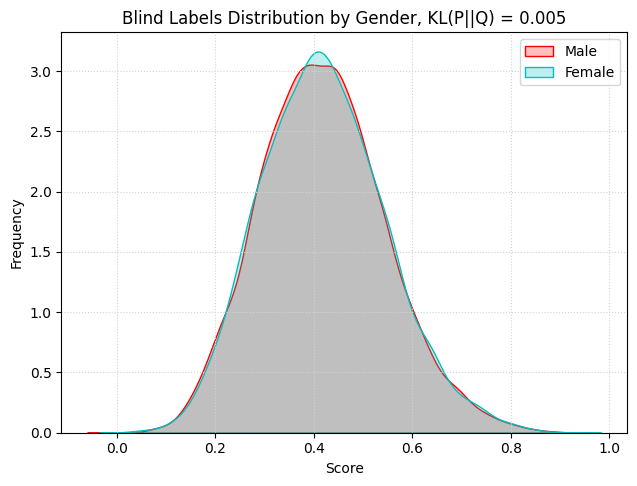

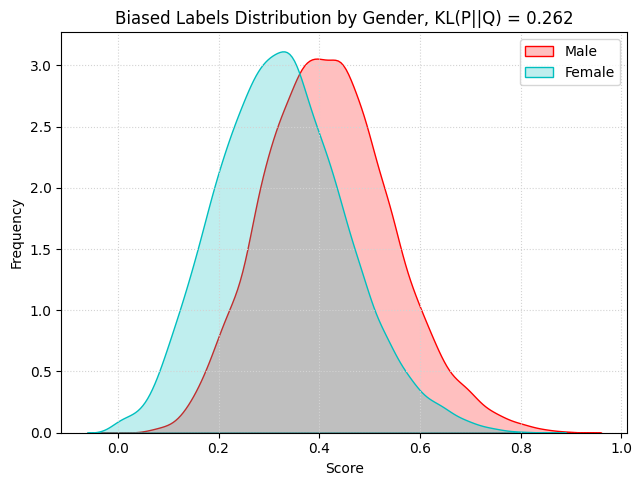

Percentage of G1 in training set = 33.36%
Percentage of G2 in training set = 33.40%
Percentage of G3 in training set = 33.24%

Percentage of G1 in test set = 33.23%
Percentage of G2 in test set = 33.08%
Percentage of G3 in test set = 33.69%



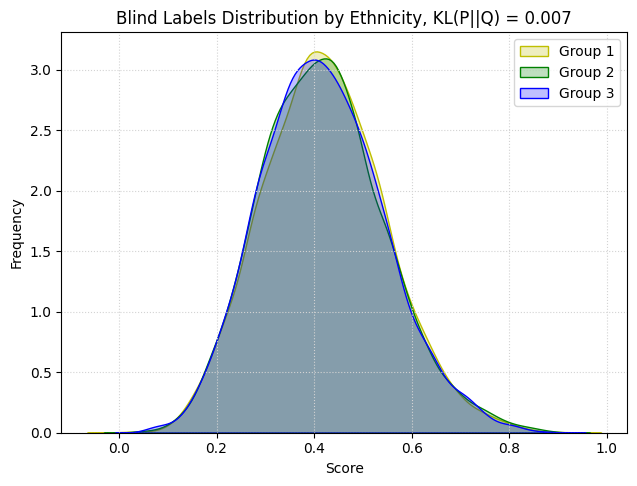

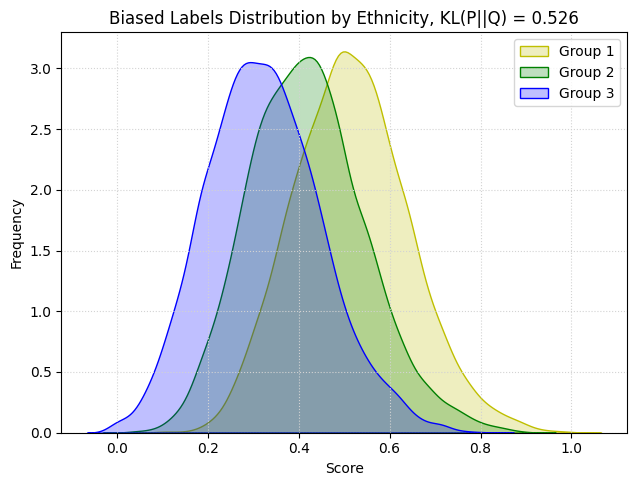

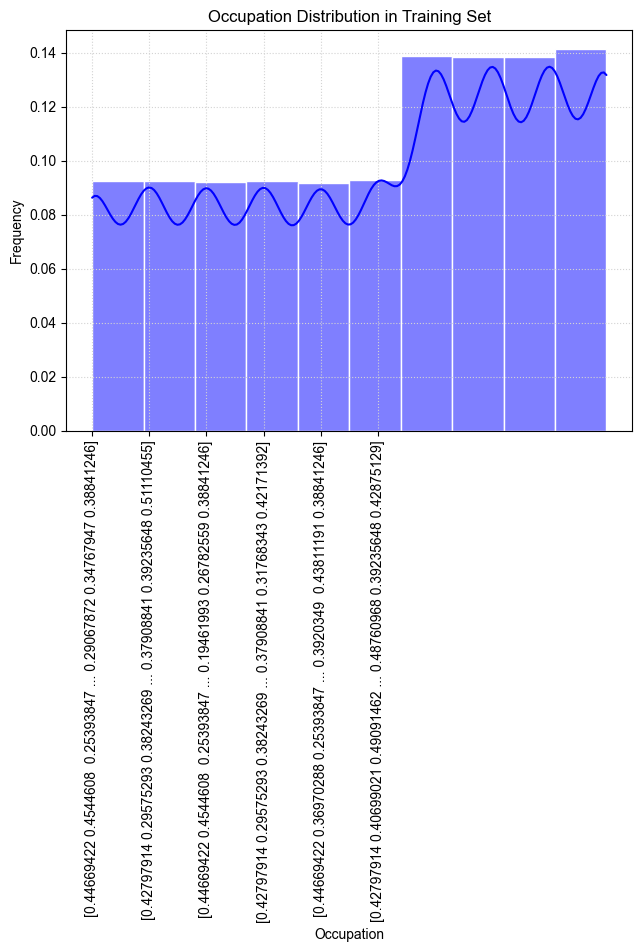

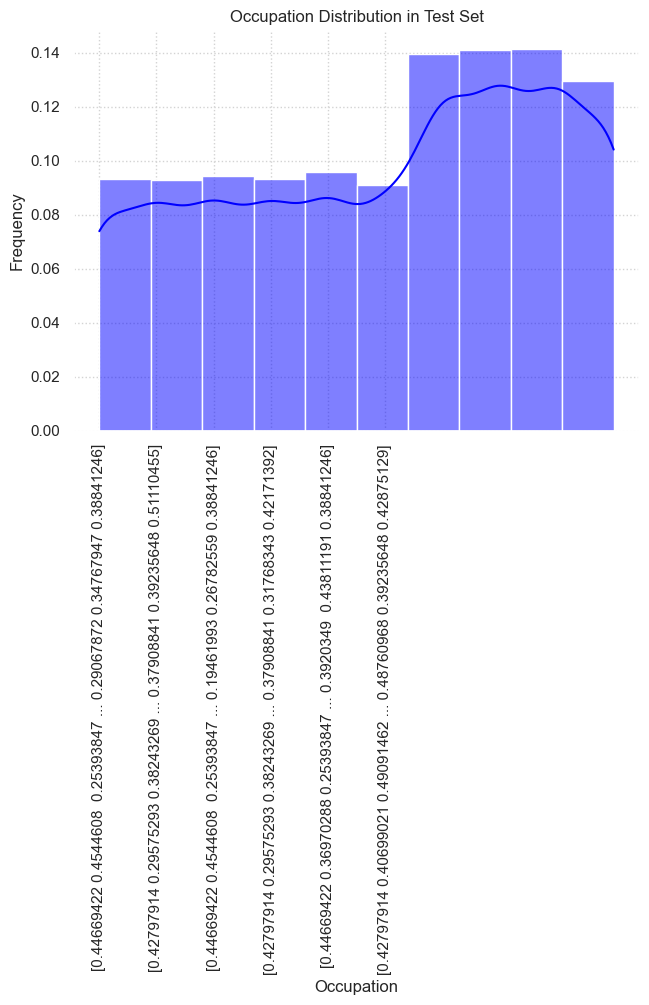

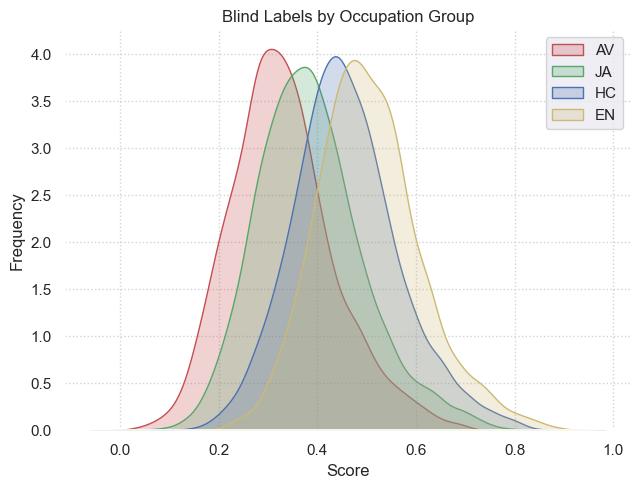

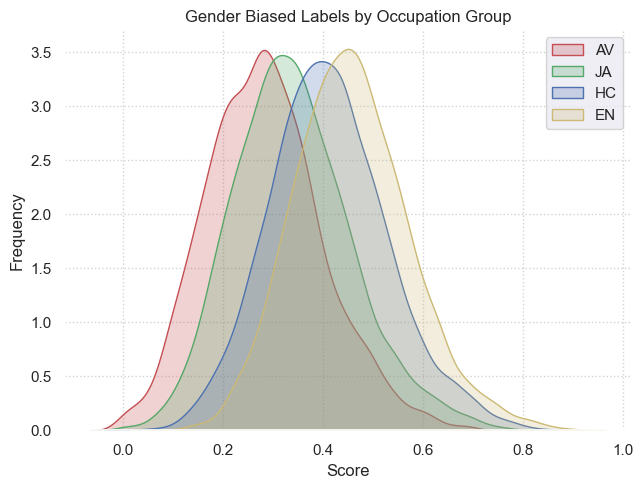

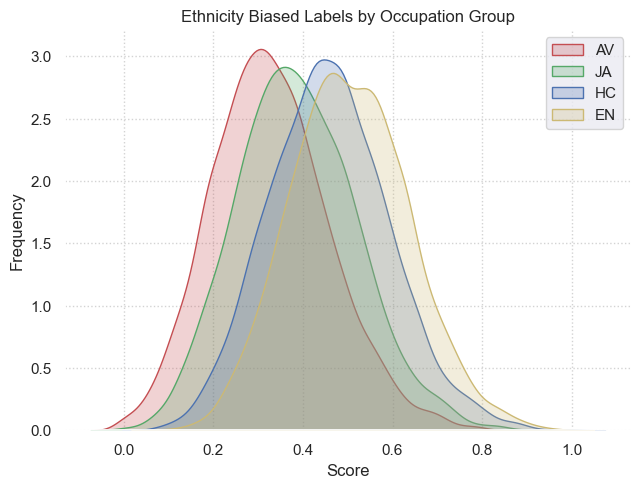

In [100]:
analyzeDatabase(data_path, database_file, bios_file)

## Summary of Results from analyzing the Dataset

### Distribution of the different Demographics within the Train & Test Sets

**Training Set:**
 - **Gender**:
      - Percentage of males: *49.81%*
      - Percentage of females: *50.19%*
 - **Ethnicity**:
      - Percentage of G1: *33.36%*
      - Percentage of G2: *33.40%*
      - Percentage of G3: *33.24%*

**Testing Set:**
 - **Gender**:
      - Percentage of males: *50.77%*
      - Percentage of females: *49.23%* 
 - **Ethnicity**:
      - Percentage of G1: *33.23%*
      - Percentage of G2: *33.08%*
      - Percentage of G3: *33.69%*
      
### Plots

#### 1. Blind Labels Distribution by Gender, KL(P||Q) = *0.005*

The graph displays the distribution of hiring outcomes, for males and females with blind labeling. With a KL divergence value of *0.005* it suggests that the distributions for males and females are nearly identical. This indicates that in blind conditions the model treats both genders equally resulting in minimal difference, between their distributions.

#### 2. Biased Labels Distribution by Gender, KL(P||Q) = *0.262*

The chart shows how men and women are hired based on biased labels criteria. The KL divergence value of *0.262* is higher, than in the blind labels scenario showing a gap in the scoring of male and female candidates. It's evident that male applicants, depicted in red tend to receive higher scores indicating a gender bias, in the hiring process.

#### 3. Blind Labels Distribution by Ethnicity, KL(P||Q) = *0.007*

The chart displays how job hires are spread out among three groups with blind labels. The small KL divergence value of *0.007* indicates that the distributions are quite alike implying that the model treats all ethnicities equally, in blind scenarios.

#### 4. Biased Labels Distribution by Ethnicity, KL(P||Q) = *0.526*

The graph illustrates how hiring outcomes are distributed among three groups based on biased labeling. The KL divergence score of *0.526* suggests a big variance, in the distributions revealing the existence of bias among ethnicities, in the models hiring choices. Each racial group exhibits peaks and variations signaling that the models evaluations differ significantly depending on ethnicity.

#### 5. Occupation Distribution in Training Set

This histogram displays how various occupations are spread out in the dataset. The labels, on the x-axis denote job categories while the y-axis indicates how often each category appears. The distribution seems uniform with some minor differences suggesting that all job categories are included in the dataset although some occur more frequently, than others.

#### 6. Occupation Distribution in Test Set

The histogram illustrates how various professions are distributed in the test group. Like the training set it showcases the diversity of occupations albeit, with some variations from the training data. This helps to ensure the test set even if not an exact match, represents the training data well.

#### 7. Blind Labels by Occupation Group

The graph displays the breakdown of hiring outcomes across job categories using blind labels. Each color corresponds to a job category (AV, JA, HC, EN). The distributions appear consistent suggesting that when using blind labels the model does not exhibit notable bias, towards any specific job category.

#### 8. Gender Biased Labels by Occupation Group

This chart displays the distribution of hiring outcomes across job categories based on gender biased labels. Each color corresponds to a unique job category. The intersection of the distributions is smaller, than in blind label cases where bias is not present suggesting that gender bias impacts the performance ratings for job categories, in varying ways.

#### 9. Ethnicity Biased Labels by Occupation Group

The chart displays the distribution of hiring outcomes across job categories labeled with ethnicity biases. The variations, in distributions indicate noticable disparities indicating that ethnicity bias influences hiring outcomes, in job sectors.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 157)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 157, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

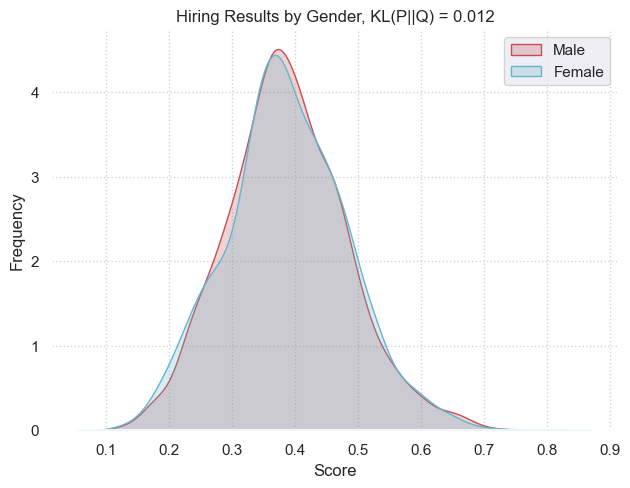

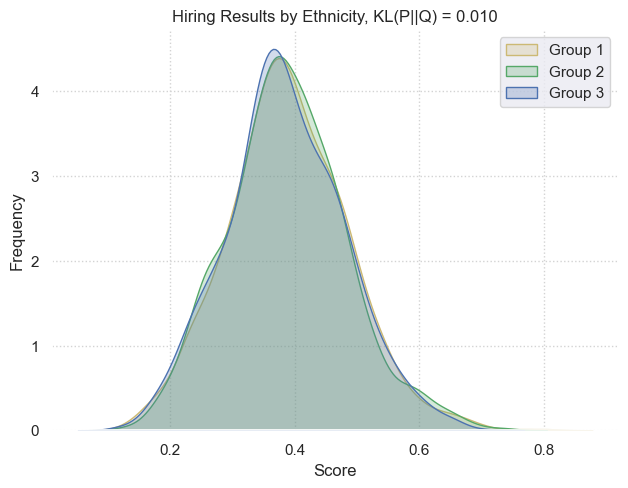

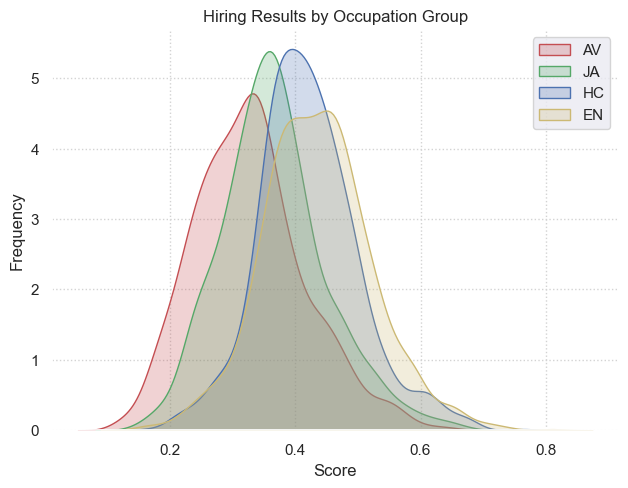

Computing Bias Metrics for configuration: neutral


Gender:
Top 100 Male: 49.40%
Top 100 Female: 50.60%
P-% Value: 97.63%
TPR Male: 46.63%
TPR Female: 46.42%
TPR Difference: 0.21%


Ethnicity:
Top 100 G1: 33.20%
Top 100 G2: 32.50%
Top 100 G3: 34.30%
P-% Value (G2/G1): 97.89%
P-% Value (G3/G1): 96.79%
P-% Value (G3/G2): 94.75%
TPR G1: 45.54%
TPR G2: 46.28%
TPR G3: 47.84%
TPR Difference(G1-G2): -0.74%
TPR Difference(G1-G3): -2.29%
TPR Difference(G2-G3): -1.56%


SVM (rbf kernel) Accuracy: 0.4821
RF Acc: 0.4517
Epoch 1/100
150/150 [==============================] - 1s 3ms/step - loss: 1.0700 - acc: 0.4091 - val_loss: 1.0507 - val_acc: 0.4458
Epoch 2/100
150/150 [==============================] - 0s 2ms/step - loss: 1.0415 - acc: 0.4469 - val_loss: 1.0412 - val_acc: 0.4535
Epoch 3/100
150/150 [==============================] - 0s 2ms/step - loss: 1.0317 - acc: 0.4637 - val_loss: 1.0311 - val_acc: 0.4648
Epoch 4/100
150/150 [==============================] - 0s 2ms/step - loss: 1.0260 - acc

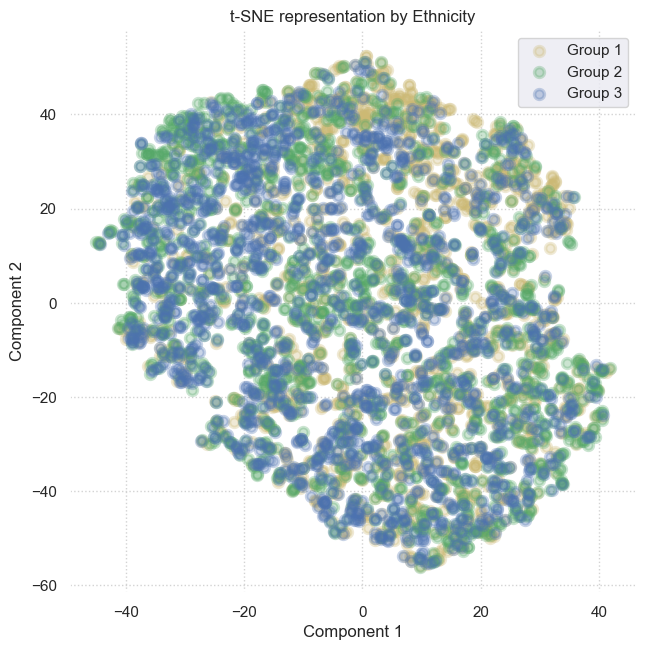

SVM (rbf kernel) Accuracy: 0.6012
RF Acc: 0.5892
Epoch 1/100
150/150 [==============================] - 1s 3ms/step - loss: 0.6827 - acc: 0.5548 - val_loss: 0.6683 - val_acc: 0.5979
Epoch 2/100
150/150 [==============================] - 0s 2ms/step - loss: 0.6686 - acc: 0.5828 - val_loss: 0.6626 - val_acc: 0.6050
Epoch 3/100
150/150 [==============================] - 0s 2ms/step - loss: 0.6646 - acc: 0.5962 - val_loss: 0.6612 - val_acc: 0.6021
Epoch 4/100
150/150 [==============================] - 0s 2ms/step - loss: 0.6610 - acc: 0.5996 - val_loss: 0.6607 - val_acc: 0.6046
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 0.6584 - acc: 0.5987 - val_loss: 0.6590 - val_acc: 0.6042
Epoch 6/100
150/150 [==============================] - 0s 2ms/step - loss: 0.6584 - acc: 0.5979 - val_loss: 0.6587 - val_acc: 0.6073
Epoch 7/100
150/150 [==============================] - 0s 2ms/step - loss: 0.6567 - acc: 0.6032 - val_loss: 0.6580 - val_acc: 0.6035
Epoch 8/100
150/150 

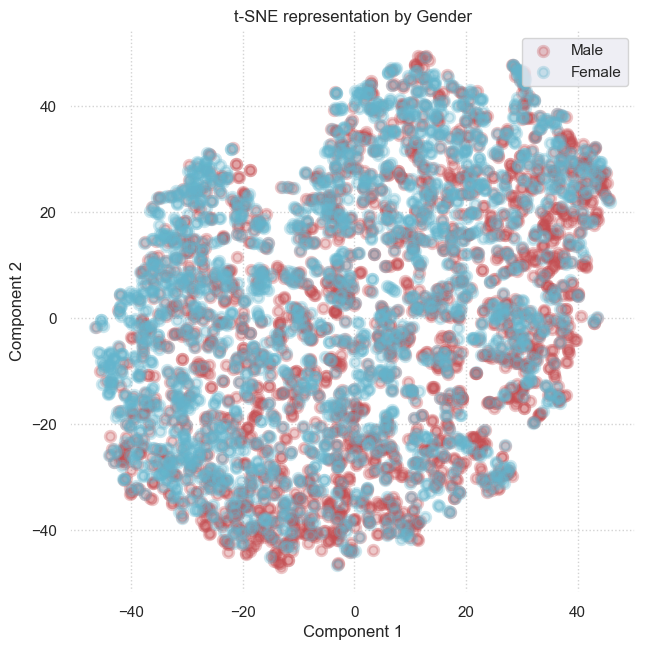

In [101]:
#Training and Testing the model for bias with neutral config

config = 'neutral'
fairCVtest(data_path, database_file, word_emb_file, config)
evaluateDemographics(data_path, database_file, config)

## Summary of Results from Model Training and Testing with Neutral Config

### Training and Evaluation Metrics

- **Model Summary**: The model which is a hybrid combining an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features and final output runs for *16* epochs adn trained on almost *90,000* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *0.024*, and the test loss (MAE) is *0.040*. So, the model performs a little worse on the test set than on the training set but it still has a relatively low loss rate.

#### Bias Metrics

1. **Top Score**:
   - **Gender**:
     - Top 100 Male: *49.40%*
     - Top 100 Female: *50.60%*
   - **Ethnicity**:
     - Top 100 G1: *33.20%*
     - Top 100 G2: *32.50%*
     - Top 100 G3: *34.30%*
   - **Observation**: There's no noticable bias among top scores between both genders and all the ethnicities which is expected as the configuration is neutral.


2. **Demographic Parity**:
   - **Gender**:
     - P-% Value: *97.63%*
   - **Ethnicity**:
     - P-% Value (G2/G1): *97.89%*
     - P-% Value (G3/G1): *96.79%*
     - P-% Value (G3/G2): *94.75%*
   - **Observation**: The values are quite good and thus means that there's little bias among the genders and among the ethnicities, a result befitting the neutral config.


3. **True Positive Rate (TPR) Differences**:
   - **Gender**:
     - TPR Male: *46.63%*
     - TPR Female: *46.42%*
     - TPR Difference: *0.21%*
   - **Ethnicity**:
     - TPR G1: *45.54%*
     - TPR G2: *46.28%*
     - TPR G3: *47.84%*
     - TPR Difference: (G1-G2): *-0.74%*
     - TPR Difference: (G1-G3): *-2.29%*
     - TPR Difference: (G2-G3): *-1.56%*
   - **Observation**: The differences in the True Positive Rates are neglible between the genders and also between the ethnicities so the model performs equally for all demographics, which again is expected for neutral config.
   
### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.012*
The first plot illustrates the distribution of hiring scores based on gender using a dist plot. A KL divergence of *0.012* indicates a minor variance, between the score distributions of men and women. Thus, the gender bias is minimal as is expected with neutral config for the dataset.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.010*
In the plot we can see how hiring scores are spread out across three ethnic groups using dist plots. The KL divergence value of *0.010* its still pretty low.

#### 3. Hiring Results by Occupation Group
The third graph displays how hiring scores are spread out among job categories (AV, JA, HC, EN) through dist plots. It's more evident that the distributions differ across job categories much more than between genders or ethnicities. This shows that the model values occupation groups more than other characteristics.

### Classifier Evaluations

These models are trained on the CV embeddings generated from the original hybrid model. With neutral congfig, model performance is evaluated for both gender and ethnicity.

**1. SVM Accuracy**:
   - **Gender:** *0.6012*
   - **Ethnicity:** *0.4821*
   - **Observation**: So, the SVM classifier correctly predicts gender *60.12%* of the time and ethnicity *48.21%* of the time. The accuracy is decent for gender but average for ethnicity. 


**2. Random Forest Accuracy**:
   - **Gender:** *0.5892*
   - **Ethnicity:** *0.4517*
   - **Observation:** So, the RF classifier correctly predicts gender *58.92%* of the time and ethnicity *45.17%* of the time. Similarly, the accuracy is decent. 


**3. Neural Network Accuracy**:
   - **Gender:** *0.6019*
   - **Ethnicity:** *0.4792*
   - **Observation**: So, the Neural Network correctly predicts gender *60.19%* of the time and ethnicity *47.92%* of the time. Again, okay accuracy for gender but not for ethnicity.
   
### t-SNE Plots

#### 1. t-SNE Representation by Ethnicity
The plot utilizes t-SNE to display the embeddings of candidates profiles in a 2-D layout with colors corresponding to ethnicity. In the t-SNE visualization, we can see that individuals, from different ethnic backgrounds are evenly distributed so the model doesn't segregate candidates solely based on ethnicity. So, ethnicity bias in the feature space is non-existant.

#### 2. t-SNE Representation by Gender
The plot also utilizes t-SNE to display the embeddings with colors representing gender this time around. Like the ethnicity plot, the gender centric t-SNE plot reveals a fair mix of male and female candidates, within the embedding space. Similar to previous plot, what this means is that gender does not strongly influence the embedding representation as well so gender bias among the embeddings is minimal.

### Conclusion

The model performs equally well for all demographics with the neutral config in which we train it on blind labels

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 157)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 157, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

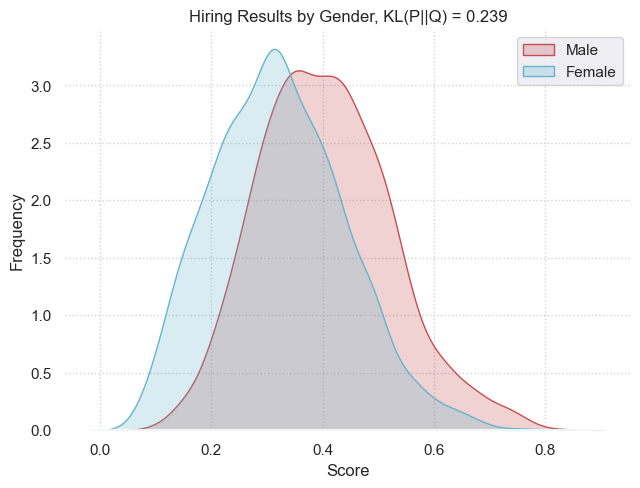

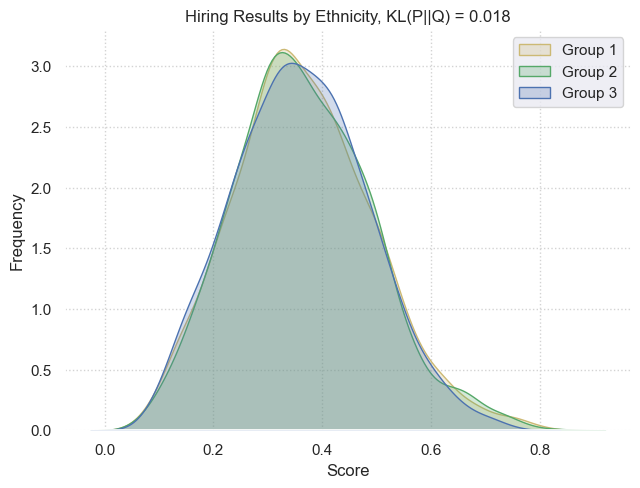

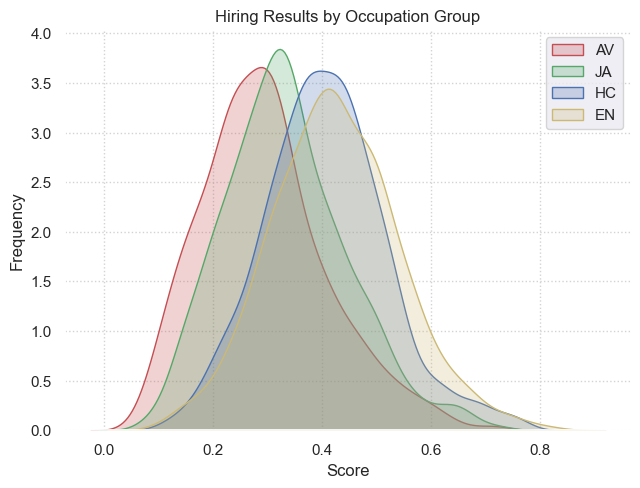

Computing Bias Metrics for configuration: gender


Top 100 Male: 71.40%
Top 100 Female: 28.60%
P-% Value: 40.06%
TPR Male: 79.26%
TPR Female: 29.14%
TPR Difference: 50.11%


SVM (rbf kernel) Accuracy: 0.8712
RF Acc: 0.8633
Epoch 1/100
150/150 [==============================] - 1s 4ms/step - loss: 0.4829 - acc: 0.7620 - val_loss: 0.3529 - val_acc: 0.8433
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 0.3634 - acc: 0.8311 - val_loss: 0.3333 - val_acc: 0.8502
Epoch 3/100
150/150 [==============================] - 0s 2ms/step - loss: 0.3456 - acc: 0.8425 - val_loss: 0.3302 - val_acc: 0.8537
Epoch 4/100
150/150 [==============================] - 0s 2ms/step - loss: 0.3339 - acc: 0.8481 - val_loss: 0.3184 - val_acc: 0.8581
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: 0.3270 - acc: 0.8518 - val_loss: 0.3138 - val_acc: 0.8621
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 0.3202 - acc: 0.8543 - val_loss: 0.30

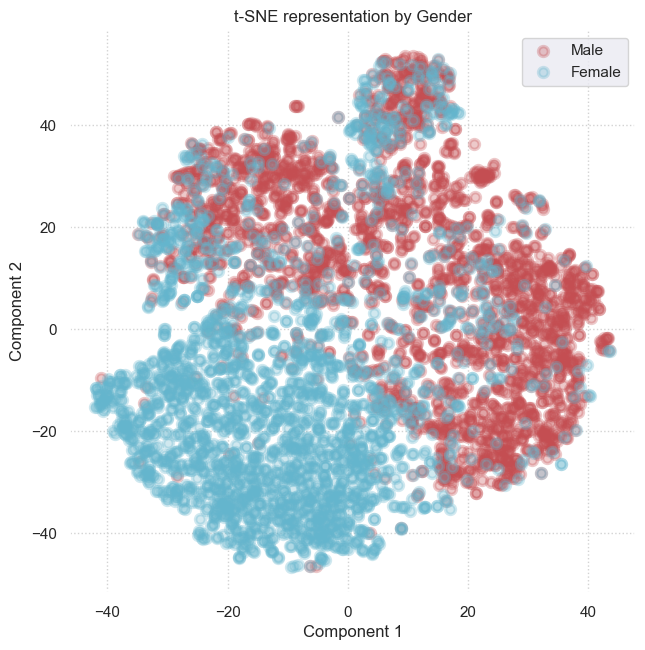

In [102]:
#Training and Testing the model for bias with gender config

config = 'gender'
fairCVtest(data_path, database_file, word_emb_file, config)
evaluateDemographics(data_path, database_file, config)

## Summary of Results from Model Training and Testing with Gender Config

### Training and Evaluation Metrics

- **Model Summary**: The model uses an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features. It was trained over *16* epochs on about *90,000* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *0.031*, and the test loss (MAE) is *0.030*. The model performs a tad bit better on the test set than on the training set and still has a low loss rate.

#### Bias Metrics

1. **Top Score**:
   - **Top 100 Male:** *71.40%*
   - **Top 100 Female:** *28.60%*
   - **Observation**: The model shows a noticeable bias towards male candidates in the top scores.

2. **Demographic Parity**:
   - **Gender**:
     - P-% Value: *40.06%*
   - **Observation**: The P-% value indicates significant bias, with male candidates being favored.

3. **True Positive Rate (TPR) Differences**:
   - **TPR Male:** *79.26%*
   - **TPR Female:** *29.14%*
   - **TPR Difference:** *50.11%*
   - **Observation**: There's a large difference in TPR between male and female candidates, which means the model performs better for male candidates.

### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.239*
The plot shows the distribution of hiring scores by gender using a dist plot. A KL divergence of *0.239* indicates a noticeable variance between male and female score distributions, showing gender bias in hiring results.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.018*
The hiring results based on ethnicity has remained more or less the same as neutral config since we have not used ethnicity biased labels.

#### 3. Hiring Results by Occupation Group
This plot shows the distribution of hiring scores across four different occupation groups using dist plots. Using gender biased labels seemed to have influenced the hiring results for certain job categories, particularly decreasing the AV category very slightly and increased the EN category a little bit. However, the overall difference from blind labels is not too much.

### Classifier Evaluations

**1. SVM Accuracy**:
   - **Gender Config:** *0.8712*
   - **Observation**: The SVM classifier predicts gender correctly *87.12%* of the time. Pretty accurate.

**2. Random Forest Accuracy**:
   - **Gender Config:** *0.8633*
   - **Observation:** The RF classifier predicts gender correctly *86.33%* of the time. Also very accurate.

**3. Neural Network Accuracy**:
   - **Gender Config:** *0.8819*
   - **Observation**: The Neural Network predicts gender correctly *88.19%* of the time. Even better accuracy.

### t-SNE Plots

#### t-SNE Representation by Gender
The t-SNE plot shows embeddings of candidate profiles in 2-D with colors representing gender. There is a clear separation between male and female candidates, indicating that gender strongly influences the embedding representation. This suggests the presence of gender bias in the feature space with more males than females in the positive quadrant.

### Conclusion

The model clearly shows bias towards Male candidates when we train it on gender labels

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 157)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 157, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

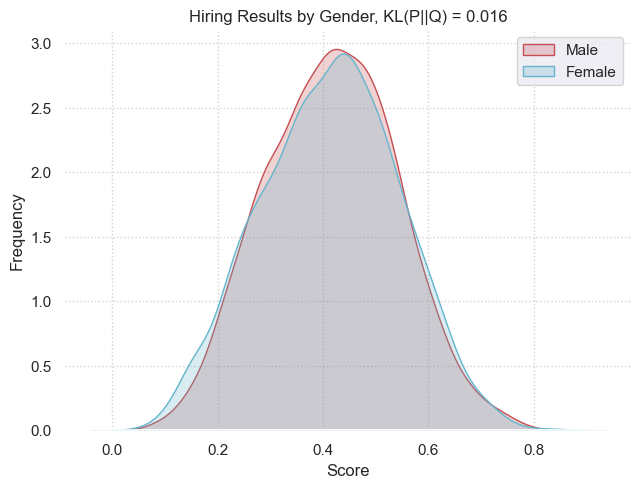

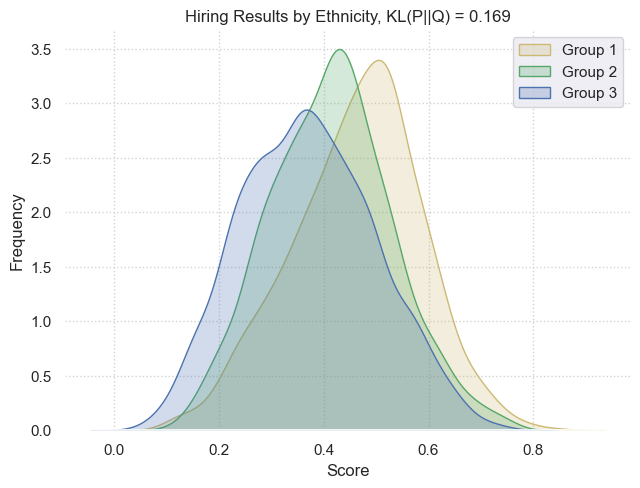

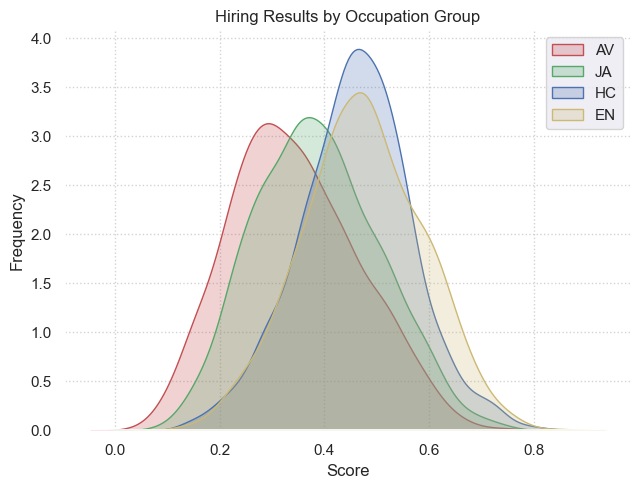

Computing Bias Metrics for configuration: ethnicity


Top 100 G1: 52.50%
Top 100 G2: 27.20%
Top 100 G3: 20.30%
P-% Value (G2/G1): 51.81%
P-% Value (G3/G1): 38.67%
P-% Value (G3/G2): 74.63%
TPR G1: 90.59%
TPR G2: 78.24%
TPR G3: 59.46%
TPR Difference(G1-G2): 12.36%
TPR Difference(G1-G3): 31.13%
TPR Difference(G2-G3): 18.78%


SVM (rbf kernel) Accuracy: 0.7225
RF Acc: 0.7221
Epoch 1/100
150/150 [==============================] - 1s 4ms/step - loss: 0.8081 - acc: 0.6597 - val_loss: 0.7153 - val_acc: 0.6998
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 0.6944 - acc: 0.7105 - val_loss: 0.6962 - val_acc: 0.7060
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 0.6799 - acc: 0.7233 - val_loss: 0.6872 - val_acc: 0.7138
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 0.6693 - acc: 0.7258 - val_loss: 0.6792 - val_acc: 0.7171
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 0.6609 - acc: 0.73

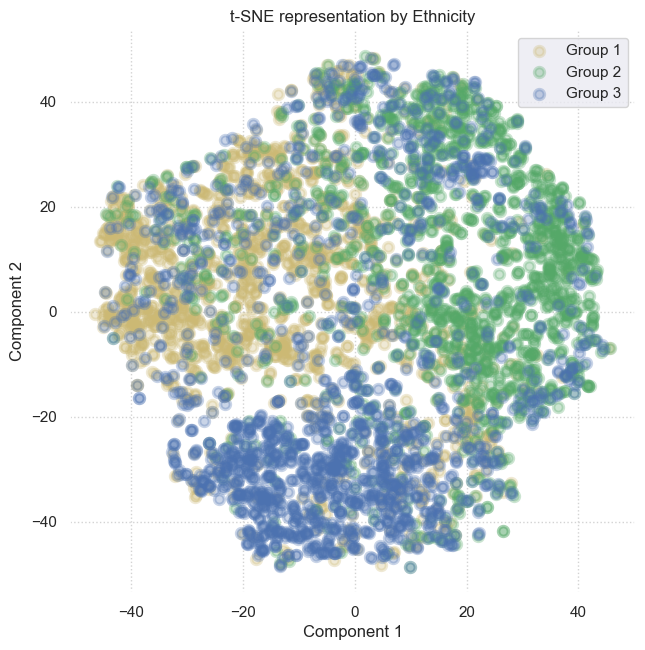

In [103]:
#Training and Testing the model for bias with ethnicity config

config = 'ethnicity'
fairCVtest(data_path, database_file, word_emb_file, config)
evaluateDemographics(data_path, database_file, config)

## Summary of Results from Model Training and Testing with Ethnicity Config

### Training and Evaluation Metrics

- **Model Summary**: The model uses an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features. It was trained over *16* epochs on about *90,000* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *0.053*, and the test loss (MAE) is *0.056*. The model performs almost equal on both the training and test sets with a low loss rate.

#### Bias Metrics

1. **Top Score**:
     - **Top 100 G1:** *52.50%*
     - **Top 100 G2:** *27.20%*
     - **Top 100 G3:** *20.30%*
   - **Observation**: The model shows a noticeable bias towards Group 1 in the top scores.

2. **Demographic Parity**:
   - **P-% Value (G2/G1):** *51.81%*
   - **P-% Value (G3/G1):** *38.67%*
   - **P-% Value (G3/G2):** *74.63%*
   - **Observation**: The P-% values indicate significant bias, with Group 1 being favored over Groups 2 and 3.

3. **True Positive Rate (TPR) Differences**:
   - **TPR G1:** *90.59%*
   - **TPR G2:** *78.24%*
   - **TPR G3:** *59.46%*
   - **TPR Difference (G1-G2):** *12.36%*
   - **TPR Difference (G1-G3):** *31.13%*
   - **TPR Difference (G2-G3):** *18.78%*
   - **Observation**: There's a significant difference in TPR between the groups, with Group 1 having the highest TPR. The TPR differences between G1 and G2 is not small but not too big, G1 and G3 is very noticable, G2 and G3 is also high. This shows that the model is biased against G3, towards G2, and highly towards G1.

### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.016*
The plot shows the distribution of hiring scores by gender using a dist plot. A KL divergence of *0.016* indicates minimal variance between male and female score distributions, showing little to no gender bias in hiring results which is expected as we're using gender blind labels.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.169*
The plot shows the distribution of hiring scores by ethnicity using a dist plot. A KL divergence of *0.169* indicates a noticeable variance between the groups, showing significant ethnicity bias in hiring results when trained with ethnicity labels.

#### 3. Hiring Results by Occupation Group
This plot shows the distribution of hiring scores across four different occupation groups using dist plots. While there a minor increases with EN and HC categories when compared with neutral config, the differences are minor indicating ethnicity has little relevance with regards to getting hired in different job categories.

### Classifier Evaluations

**1. SVM Accuracy**:
   - **Ethnicity Config:** *0.7546*
   - **Observation**: The SVM classifier predicts ethnicity correctly *75.46%* of the time. Above average accuracy.

**2. Random Forest Accuracy**:
   - **Ethnicity Config:** *0.7554*
   - **Observation:** The RF classifier predicts ethnicity correctly *75.54%* of the time. Similar accuracy to SVM.

**3. Neural Network Accuracy**:
   - **Ethnicity Config:** *0.7615*
   - **Observation**: The Neural Network predicts ethnicity correctly *76.15%* of the time. Slightly performs better than the SVM and RF models.

### t-SNE Plots

#### t-SNE Representation by Ethnicity
The t-SNE plot shows embeddings of candidate profiles in 2-D with colors representing ethnicity. There is a noticeable separation between the different ethnic groups, indicating that ethnicity strongly influences the embedding representation. This suggests the presence of ethnicity bias in the feature space, with Group 1 and Group 2 candidates favoured more than Group 3.

### Conclusion

The model clearly shows bias towards Group 1(Caucasian) and Group 2(Asian) ethnic groups when we train it on ethnicity labels.

# Bias Mitigation

### Three Approaches were explored to mitigate bias in the hiring tool

**1. Adversarial debiasing** - Introducing a gradient reversal layer that encourages the main network to learn features that are invariant to sensitive attributes. The model is trained with a combination of loss functions for both the main task and the adversarial task, with the ability to adjust the adversarial loss weight to balance performance and bias mitigation.
   
**2. Building a SensitiveNets Model** - Training a model that specifically uses agnostic labels for gender and ethnicity to remove their impact on model predictions.
   
**3. Building a Hybrid Model** - Combining predictions from a Random Forest classifier with a Neural Network, both trained on CV embeddings from the hiring tool, to create a hybrid model.

## Adversarial Debiasing

In [33]:
from tensorflow.keras.layers import Lambda

def gradient_reversal(x):
    @tf.custom_gradient
    def _gradient_reversal(op):
        def grad(dy):
            return -dy
        return op, grad
    return _gradient_reversal(x)

In [34]:
def adversarial_debiasing_model(profiles_shape, bios_shape, data_path, word_emb_file, t, sensitive_attr_dim):
    embedding_dim, word_embeddings = load_vectors(os.path.join(data_path, word_emb_file))
    embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))
    for word, i in t.word_index.items():
        if i < MAX_WORDS:
            embedding_vector = word_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    del word_embeddings

    text_input = Input(shape=(bios_shape,))
    embedding = Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=bios_shape,
                          weights=[embedding_matrix], trainable=False)(text_input)
    text_embedding = Bidirectional(LSTM(32, activation='tanh'))(embedding)

    feature_input = Input(shape=(profiles_shape,))
    concat = Concatenate()([feature_input, text_embedding])
    x = Dense(40, activation='relu', name='embedding_layer')(concat)
    x = Dropout(0.3)(x)
    x = Dense(20, activation='relu')(x)
    hiring_output = Dense(1, activation='sigmoid')(x)
    
    # Gradient reversal layer
    reversed_feature = Lambda(gradient_reversal)(x)
    adversary_output = Dense(sensitive_attr_dim, activation='softmax')(reversed_feature)

    model = keras.Model(inputs=[feature_input, text_input], outputs=[hiring_output, adversary_output])
    model.summary()
    return model

In [35]:
def train_adversarial_debiasing_model(model, profiles_train, bios_train, labels_train, sensitive_attr_train, batch_size=128, epochs=16, adv_loss_weight=0.1):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss=[keras.losses.MeanAbsoluteError(), keras.losses.CategoricalCrossentropy()],
                  loss_weights=[1.0, adv_loss_weight])
    
    history = model.fit([profiles_train, bios_train], [labels_train, sensitive_attr_train],
                        batch_size=batch_size, epochs=epochs, validation_split=0.1)
    
    print('Training loss (MAE): {:.3f}'.format(history.history['loss'][-1]))
    return model, history

In [36]:
def evaluate_adversarial_debiasing_model(model, profiles_test, bios_test, labels_test, sensitive_attr_test):
    scores_loss = model.evaluate([profiles_test, bios_test], [labels_test, sensitive_attr_test])
    
    print('Test loss (MAE): {:.3f}'.format(scores_loss[0]))
    
    scores = model.predict([profiles_test, bios_test])[0]
    
    return scores

In [37]:
def fairCVtestAdversarialDebiasing(data_path, database_file, word_emb_file, config, adv_loss_weight=0.1):
    keras.backend.clear_session()
    
    labels_train, labels_test, profiles_train, profiles_test, bios_train, bios_test = loadDataset(data_path, database_file, config)
    labels_train_main = labels_train[:, 0]
    labels_test_main = labels_test[:, 0]
    
    sensitive_attr_train = labels_train[:, 1]
    sensitive_attr_test = labels_test[:, 1]
    
    sensitive_attr_train = keras.utils.to_categorical(sensitive_attr_train)
    sensitive_attr_test = keras.utils.to_categorical(sensitive_attr_test)

    bios_train, t, max_len = processBios(bios_train)
    bios_test, _, _ = processBios(bios_test, t, max_len)

    model = adversarial_debiasing_model(profiles_train.shape[1], max_len, data_path, word_emb_file, t, sensitive_attr_train.shape[1])
    model, history = train_adversarial_debiasing_model(model, profiles_train, bios_train, labels_train_main, sensitive_attr_train, adv_loss_weight=adv_loss_weight)
    scores = evaluate_adversarial_debiasing_model(model, profiles_test, bios_test, labels_test_main, sensitive_attr_test)

    saveResults(data_path, config, model, t, history, scores, max_len)
    analyzeResults(data_path, database_file, config)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 157)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 157, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

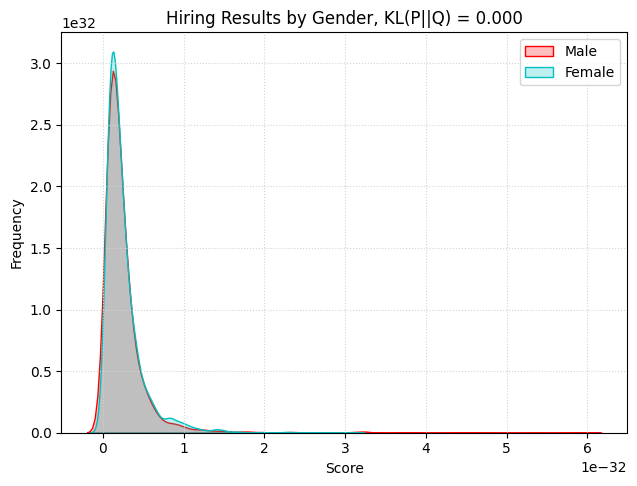

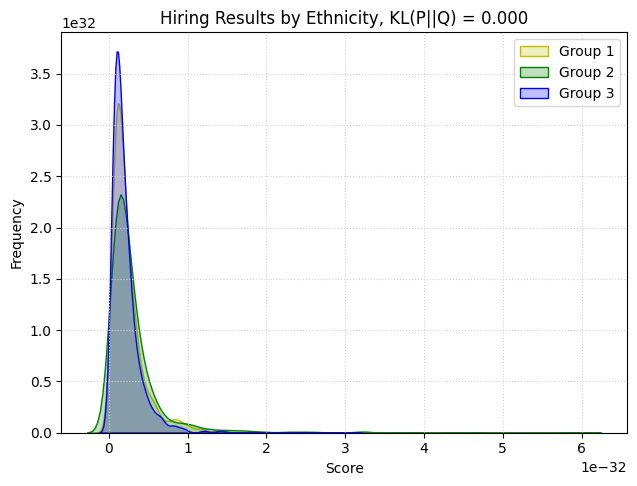

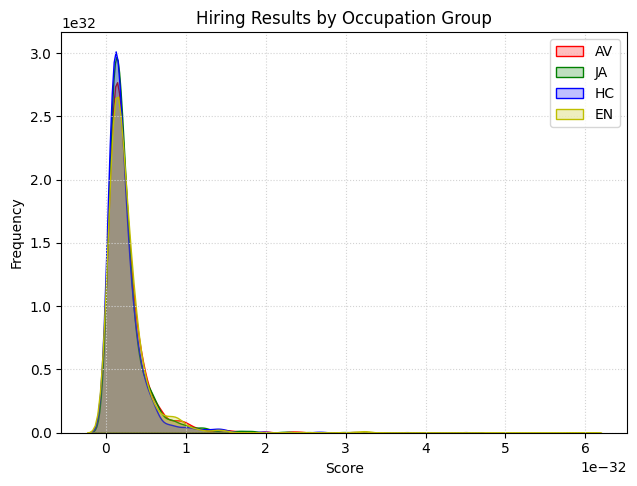

Computing Bias Metrics for configuration: ethnicity


Top 100 G1: 32.80%
Top 100 G2: 41.50%
Top 100 G3: 25.70%
P-% Value (G2/G1): 79.04%
P-% Value (G3/G1): 78.35%
P-% Value (G3/G2): 61.93%
TPR G1: 0.00%
TPR G2: 0.00%
TPR G3: 0.00%
TPR Difference(G1-G2): 0.00%
TPR Difference(G1-G3): 0.00%
TPR Difference(G2-G3): 0.00%




In [99]:
# Training & Testing the adversarial model for ethnicity config with loss weights optimal for bias mitigation
fairCVtestAdversarialDebiasing(data_path, database_file, word_emb_file, 'ethnicity', adv_loss_weight=0.69)

## Summary of Results from Adversarial Model Training and Testing for Ethnicity Config with Loss Weights optimal for Bias Mitigation

### Training and Evaluation Metrics

- **Model Summary**: The model uses an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features. It was trained over *16* epochs on about *90,000* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *1.200*, and the test loss (MAE) is *1.210*. The model performs almost equally on both the training and test sets both of which are very bad.

#### Bias Metrics

1. **Top Score**:
   - **Top 100 G1:** *32.80%*
   - **Top 100 G2:** *41.50%*
   - **Top 100 G3:** *25.70%*
   - **Observation:** Although there's minor bias towards G2 and against G3, the bias overall has been reduced significantly


2. **Demographic Parity**:
   - **P-% Value (G2/G1):** *79.04%*
   - **P-% Value (G3/G1):** *78.35%*
   - **P-% Value (G3/G2):** *61.93%*
   - **Observation:** Again, while G1 and G2 are favoured more, the bias has been mitigated quite well.


3. **True Positive Rate (TPR) Differences**:
   - **TPR G1:** *0.00%*
   - **TPR G2:** *0.00%*
   - **TPR G3:** *0.00%*
   - **TPR Difference (G1-G2):** *0.00%*
   - **TPR Difference (G1-G3):** *0.00%*
   - **TPR Difference (G2-G3):** *0.00%*
   - **Observation**: The model fails to predict any of the scores correctly. However, this is intentional as my goal was simply to show that bias can be regulated to this degree.

### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.000*
This plot shows the distribution of hiring scores for male and female candidates. The distribution appears almost identical for both groups, suggesting no gender bias exists. The KL divergence value of 0.000 indicates no divergence between the distributions of scores for male and female candidates.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.000*
This plot illustrates the distribution of hiring scores across three ethnic groups (Group 1, Group 2, and Group 3). The distributions for all three groups are nearly identical, indicating that the model does not show significant bias towards any particular ethnic group. The KL divergence value of 0.000 confirms the lack of substantial divergence between the score distributions for these groups.

#### 3. Hiring Results by Occupation Group
This plot depicts the distribution of hiring scores for candidates from four different occupation groups (AV, JA, HC, and EN). Similar to the previous plots, the distributions for all occupation groups are nearly identical, suggesting no substantial bias in the model's hiring scores based on occupation.

### Comparison with Default Model (with ethnicity config)

| Metric                      |    Default Model    |    Adversarial Model    |
|:----------------------------|:-------------------:|:-----------------------:|
| Top 100 G1 (%)              | *52.50*             | *32.80*                 |
| Top 100 G2 (%)              | *27.20*             | *41.50*                 |
| Top 100 G3 (%)              | *20.30*             | *25.70*                 |
| P-% Value (G2/G1) (%)       | *51.81*             | *79.04*                 |
| P-% Value (G3/G1) (%)       | *38.67*             | *78.35*                 |
| P-% Value (G3/G2) (%)       | *74.63*             | *61.93*                 |
| TPR G1 (%)                  | *90.59*             | *0.00*                  |
| TPR G2 (%)                  | *78.24*             | *0.00*                  |
| TPR G3 (%)                  | *59.46*             | *0.00*                  |
| TPR Difference (G1-G2) (%)  | *12.36*             | *0.00*                  |
| TPR Difference (G1-G3) (%)  | *31.13*             | *0.00*                  |
| TPR Difference (G2-G3) (%)  | *18.78*             | *0.00*                  |


### Conclusion

The adversarial model still shows slight bias towards Group 2 and 1 but the overall bias against Groups 2 and 3 have been reduced greatly when trained with the ethnicity-biased labels. The loss of the model is terrible, however this is intentional as I simply wanted to mitigate the bias as much as I can without caring about the performance. Increasing the adversarial loss weight further causes the model to break completely and make it biased towards Group 2 entirely.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 157)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 157, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

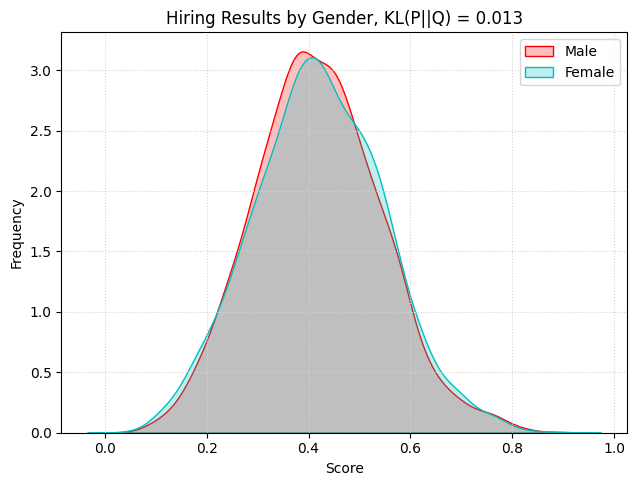

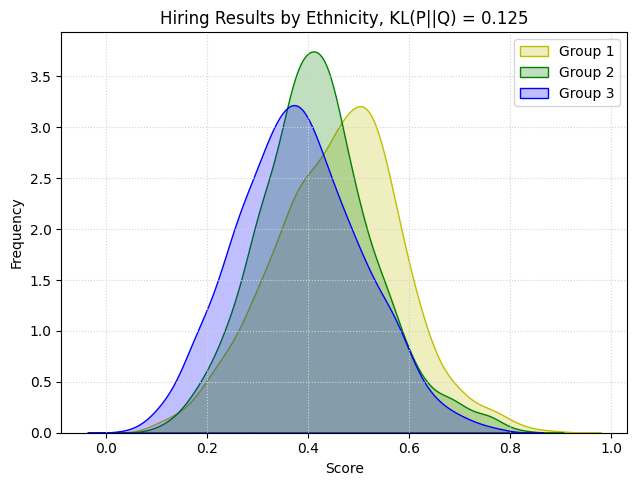

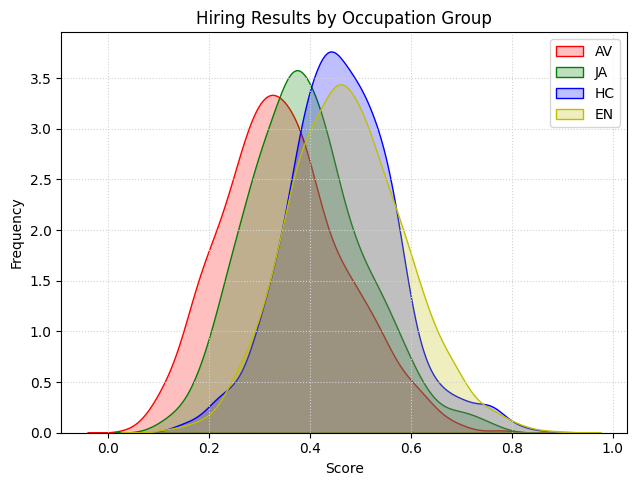

Computing Bias Metrics for configuration: ethnicity


Top 100 G1: 50.60%
Top 100 G2: 26.50%
Top 100 G3: 22.90%
P-% Value (G2/G1): 52.37%
P-% Value (G3/G1): 45.26%
P-% Value (G3/G2): 86.42%
TPR G1: 91.09%
TPR G2: 77.13%
TPR G3: 66.49%
TPR Difference(G1-G2): 13.95%
TPR Difference(G1-G3): 24.60%
TPR Difference(G2-G3): 10.65%




In [62]:
# Training & Testing the adversarial model for ethnicity config with adversarial loss weights
# Optimal for ensuring acceptable performance while mitigating bias
fairCVtestAdversarialDebiasing(data_path, database_file, word_emb_file, 'ethnicity', adv_loss_weight=0.114)

## Summary of Results from Adversarial Model Training and Testing for Ethnicity Config with Loss Weights optimal for Ensuring Performance while Mitigating Bias

### Training and Evaluation Metrics

- **Model Summary**: The model uses an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features. It was trained over *16* epochs on about *90,000* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *0.176*, and the test loss (MAE) is *0.179*. The model performs almost equally on both the training and test sets.

#### Bias Metrics

1. **Top Score**:
   - **Top 100 G1:** *50.60%*
   - **Top 100 G2:** *26.50%*
   - **Top 100 G3:** *22.90%*
   - **Observation:** The reductions in bias among the ethnicities is rather minimal


2. **Demographic Parity**:
   - **P-% Value (G2/G1):** *52.37%*
   - **P-% Value (G3/G1):** *45.26%*
   - **P-% Value (G3/G2):** *86.42%*
   - **Observation:** The values have been equalized to a degree but there's still bias towards G1


3. **True Positive Rate (TPR) Differences**:
   - **TPR G1:** *91.09%*
   - **TPR G2:** *77.13%*
   - **TPR G3:** *66.49%*
   - **TPR Difference (G1-G2):** *13.95%*
   - **TPR Difference (G1-G3):** *24.60%*
   - **TPR Difference (G2-G3):** *10.65%*
   - **Observation**: The performance of the model for G2 has increased slightly while for G3, it has improved greatly. Thus, the differences in TPR were minimized, in-turn reducing the bias as well.

### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.013*
This plot shows the distribution of hiring scores for male and female candidates. The distributions are almost overlapping with a KL divergence of 0.013, indicating a very slight difference between the distributions of scores for males and females.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.125*
This plot illustrates the distribution of hiring scores across three ethnic groups (Group 1, Group 2, and Group 3). The KL divergence of 0.125 suggests a noticeable difference in the distributions. Group 2 has the highest frequency while Group 1 has the highest scores.

#### 3. Hiring Results by Occupation Group
This plot depicts the distribution of hiring scores for candidates from four different occupation groups (AV, JA, HC, and EN). The distributions overlap to some extent but have distinct peaks, indicating differences in scores across occupation groups.

### Comparison with Default Model (with ethnicity config)

| Metric                      |    Default Model    |    Adversarial Model    |
|:----------------------------|:-------------------:|:-----------------------:|
| Top 100 G1 (%)              | *52.50*             | *50.60*                 |
| Top 100 G2 (%)              | *27.20*             | *26.50*                 |
| Top 100 G3 (%)              | *20.30*             | *22.90*                 |
| P-% Value (G2/G1) (%)       | *51.81*             | *52.37*                 |
| P-% Value (G3/G1) (%)       | *38.67*             | *45.26*                 |
| P-% Value (G3/G2) (%)       | *74.63*             | *86.42*                 |
| TPR G1 (%)                  | *90.59*             | *91.09*                 |
| TPR G2 (%)                  | *78.24*             | *77.13*                 |
| TPR G3 (%)                  | *59.46*             | *66.49*                 |
| TPR Difference (G1-G2) (%)  | *12.36*             | *13.95*                 |
| TPR Difference (G1-G3) (%)  | *31.13*             | *24.60*                 |
| TPR Difference (G2-G3) (%)  | *18.78*             | *10.65*                 |


### Conclusion

The adversarial model is still biased towards Group 1. The bias against Groups 2 and 3 have been minimized slightly when trained with the ethnicity-biased labels. The loss of the model while not the best, is acceptable. This is the highest degree to which I could mitigate the bias among the ethnicity groups without breaking the model's predictive capabilities. Increasing the adversarial loss weight any further causes the model to stop predicting the positive scores altogether, leading to a TPR of 0.00% for all groups.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 157)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 157, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

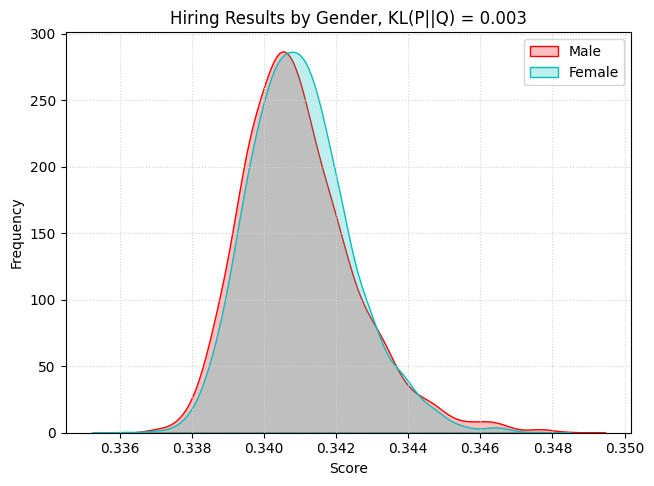

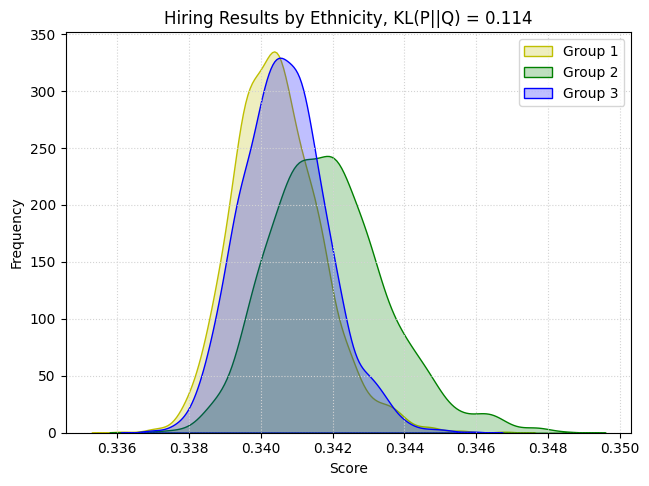

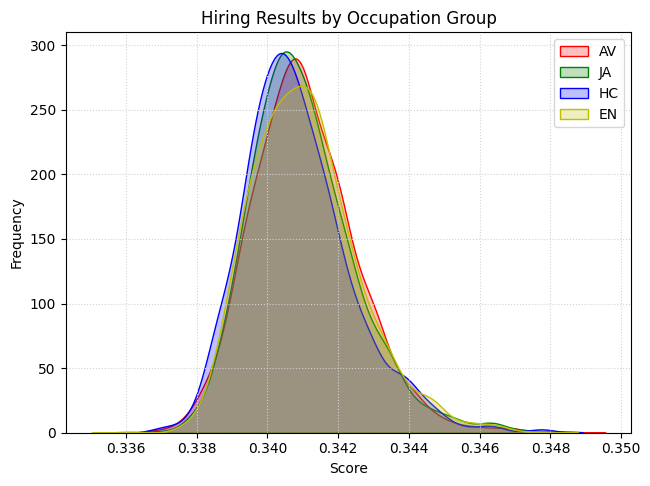

Computing Bias Metrics for configuration: gender


Top 100 Male: 50.20%
Top 100 Female: 49.80%
P-% Value: 99.20%
TPR Male: 0.00%
TPR Female: 0.00%
TPR Difference: 0.00%




In [90]:
# Training & Testing the adversarial model for gender config with loss weights optimal for bias mitigation
fairCVtestAdversarialDebiasing(data_path, database_file, word_emb_file, 'gender', adv_loss_weight=0.7755)

## Summary of Results from Adversarial Model Training and Testing for Gender Config with Loss Weights optimal for Bias Mitigation

### Training and Evaluation Metrics

- **Model Summary**: The model uses an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features. It was trained over *16* epochs on about *6,089,769* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *0.681*, and the test loss (MAE) is *0.652*. The model performs slightly worse on the test set than on the training set.

#### Bias Metrics

1. **Top Score**:
   - **Top 100 Male:** *50.20%*
   - **Top 100 Female:** *49.80%*
   - **Observation:** The model shows an almost balanced distribution of top scores between male and female candidates, meaning the gender bias has been all but eliminated.


2. **Demographic Parity**:
   - **P-% Value:** *99.20%*
   - **Observation:** The P-% value is almost perfect, indicating almost no bias towards either gender in the hiring process.


3. **True Positive Rate (TPR) Differences**:
   - **TPR Male:** *0.00%*
   - **TPR Female:** *0.00%*
   - **TPR Difference:** *0.00%*
   - **Observation:** The model fails to predict any of the scores correctly. However, this is intentional as my goal was simply to show that bias can be regulated to this degree.


### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.003*
The plot shows the distribution of hiring scores by gender using a dist plot. A KL divergence of *0.003* indicates essentially no variance between male and female score distributions, so there's no bias in hiring results.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.114*
The plot shows the distribution of hiring scores by ethnicity using a dist plot. A KL divergence of *0.114* indicates noticeable but not extreme difference in the distributions. Groups 1 & 3 are higher in frequency while Group 2 has higher scores

#### 3. Hiring Results by Occupation Group
This plot shows the distribution of hiring scores across four different occupation groups using dist plots. The distributions overlap significantly, indicating that occupation does not create significant differences in hiring scores. The lines for each occupation group follow closely, suggesting equitable treatment across these groups.

### Comparison with Default Model (with gender config)

| Metric               |    Default Model    |    Adversarial Model    |
|:---------------------|:-------------------:|:-----------------------:|
| Top 100 Male (%)     | *71.40*             | *50.20*                 |
| Top 100 Female (%)   | *28.60*             | *49.80*                 |
| P-% Value (%)        | *40.06*             | *99.20*                 |
| TPR Male (%)         | *79.26*             | *0.00*                  |
| TPR Female (%)       | *29.14*             | *0.00*                  |
| TPR Difference (%)   | *50.11*             | *0.00*                  |


### Conclusion

The adversarial model shows almost no bias towards or against any specific gender when trained with gender-biased labels. The loss of the model is terrible, however this is intentional as I simply wanted to mitigate the bias as much as I can without caring about the performance. Increasing the adversarial loss weight further causes the model to be more biased towards females.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 157)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 157, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

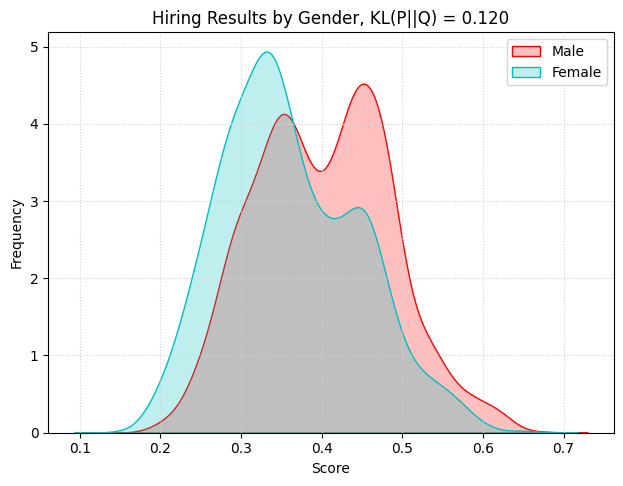

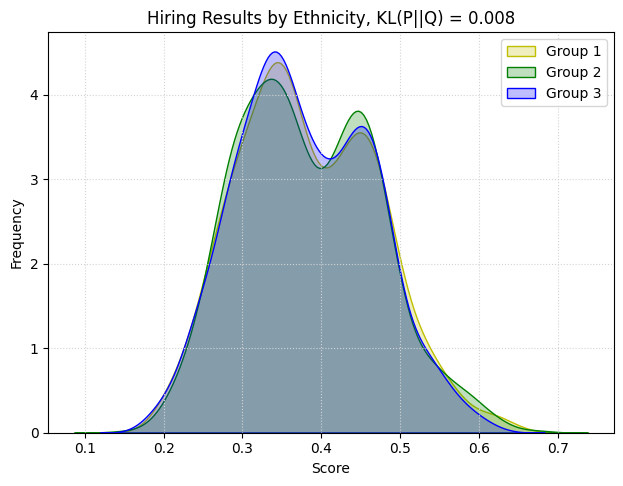

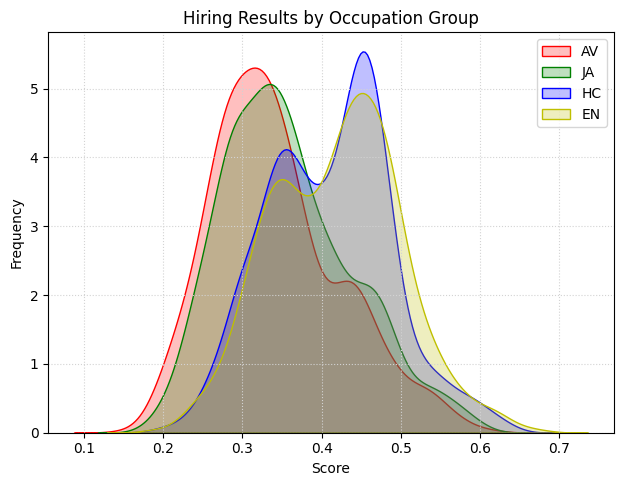

Computing Bias Metrics for configuration: gender


Top 100 Male: 66.10%
Top 100 Female: 33.90%
P-% Value: 51.29%
TPR Male: 44.86%
TPR Female: 24.43%
TPR Difference: 20.43%




In [54]:
# Training & Testing the adversarial model for gender config with adversarial loss weights
# Optimal for ensuring acceptable performance while mitigating bias
fairCVtestAdversarialDebiasing(data_path, database_file, word_emb_file, 'gender', adv_loss_weight=0.095)

## Summary of Results from Adversarial Model Training and Testing for Gender Config with Loss Weights optimal for Ensuring Performance while Mitigating Bias

### Training and Evaluation Metrics

- **Model Summary**: The model uses an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features. It was trained over *16* epochs on about *6,089,769* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *0.128*, and the test loss (MAE) is *0.119*. The model performs slightly worse on the test set than on the training set.

#### Bias Metrics

1. **Top Score**:
   - **Top 100 Male:** *66.10%*
   - **Top 100 Female:** *33.90%*
   - **Observation:** The model is twice as likely to favour male candidates.


2. **Demographic Parity**:
   - **P-% Value:** *51.29%*
   - **Observation:** The P-% value is halved, which means females are only half as likely as males to be considered.

3. **True Positive Rate (TPR) Differences**:
   - **TPR Male:** *44.86%*
   - **TPR Female:** *24.43%*
   - **TPR Difference:** *20.43%*
   - **Observation:** The model performs 20% better for male candidates, indicating bias towards males.


### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.120*
The plot shows the distribution of hiring scores by gender using a dist plot. The KL divergence of 0.120 suggests a noticeable divergence between the distributions of scores for male and female candidates, with males having higher scores.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.008*
The plot shows the distribution of hiring scores by ethnicity using a dist plot. The distributions are fairly similar, with slight variations. The KL divergence of 0.008 suggests minimal divergence between the distributions of scores for different ethnic groups, indicating a relatively low level of bias in the hiring results based on ethnicity.

#### 3. Hiring Results by Occupation Group
This plot shows the hiring scores distribution across four different occupation groups (AV, JA, HC, EN). The distributions show some variation, particularly in the peaks and spread of scores, suggesting that occupation group may influence hiring scores to some extent.

### Comparison with Default Model (with gender config)

| Metric               |    Default Model    |    Adversarial Model    |
|:---------------------|:-------------------:|:-----------------------:|
| Top 100 Male (%)     | *71.40*             | *66.10*                 |
| Top 100 Female (%)   | *28.60*             | *33.90*                 |
| P-% Value (%)        | *40.06*             | *51.29*                 |
| TPR Male (%)         | *79.26*             | *44.86*                 |
| TPR Female (%)       | *29.14*             | *24.43*                 |
| TPR Difference (%)   | *50.11*             | *20.43*                 |


### Conclusion

The adversarial model is still biased towards male candidates. The bias against females have been minimized slightly when trained with the gender-biased labels.The loss of the model while not the best, is acceptable. This is the highest degree to which I could mitigate the bias between the genders without breaking the model's predictive capabilities. Increasing the adversarial loss weight any further causes the model to stop predicting the positive scores altogether, leading to a TPR of 0.00% for both genders.

## SensitiveNets Approach

In [40]:
#Load the FairCV dataset based on the Agnostic config
def loadAgnosticDataset(data_path, database_file, config):
    
    fairCV = np.load(os.path.join(data_path, database_file), allow_pickle = True).item()
    profiles_train = fairCV['Profiles Train']
    profiles_test = fairCV['Profiles Test']

    if config == 'agnostic ethnicity':
        labels_train = np.expand_dims(fairCV['Biased Labels Train (Ethnicity)'], axis=1)
        labels_test = np.expand_dims(fairCV['Biased Labels Test (Ethnicity)'], axis=1)
        ethnicity_labels_train = np.expand_dims(profiles_train[:,0], axis=1)
        ethnicity_labels_test = np.expand_dims(profiles_test[:,0], axis=1)

        labels_train = np.concatenate((labels_train, ethnicity_labels_train), axis=1)
        labels_test = np.concatenate((labels_test, ethnicity_labels_test), axis=1)

        profiles_train = np.concatenate((profiles_train[:,4:11], profiles_train[:,31:]), axis=1)
        profiles_test = np.concatenate((profiles_test[:,4:11], profiles_test[:,31:]), axis=1)

        bios_train = fairCV['Bios Train'][:,1]
        bios_test = fairCV['Bios Test'][:,1]

    elif config == 'agnostic gender':
        labels_train = np.expand_dims(fairCV['Biased Labels Train (Gender)'], axis=1)
        labels_test = np.expand_dims(fairCV['Biased Labels Test (Gender)'], axis=1)
        gender_labels_train = np.expand_dims(profiles_train[:,1], axis=1)
        gender_labels_test = np.expand_dims(profiles_test[:,1], axis=1)

        labels_train = np.concatenate((labels_train, gender_labels_train), axis=1)
        labels_test = np.concatenate((labels_test, gender_labels_test), axis=1)

        profiles_train = np.concatenate((profiles_train[:,4:11], profiles_train[:,31:]), axis=1)
        profiles_test = np.concatenate((profiles_test[:,4:11], profiles_test[:,31:]), axis=1)

        bios_train = fairCV['Bios Train'][:,1]
        bios_test = fairCV['Bios Test'][:,1]
        
    return labels_train, labels_test, profiles_train, profiles_test, bios_train, bios_test

In [41]:
def sensitiveNetModel(profiles_shape, bios_shape, data_path, word_emb_file, t):
    embedding_dim, word_embeddings = load_vectors(os.path.join(data_path, word_emb_file))
    embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))
    for word, i in t.word_index.items():
        if i < MAX_WORDS:
            embedding_vector = word_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    del word_embeddings

    text_input = Input(shape=(bios_shape,))
    embedding = Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=bios_shape,
                          weights=[embedding_matrix], trainable=False)(text_input)
    text_embedding = Bidirectional(LSTM(32, activation='tanh'))(embedding)

    feature_input = Input(shape=(profiles_shape,))
    concat = Concatenate()([feature_input, text_embedding])
    x = Dense(40, activation='relu', name='embedding_layer')(concat)
    x = Dropout(0.3)(x)
    x = Dense(20, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[feature_input, text_input], outputs=output)
    model.summary()
    return model

In [42]:
def trainSensitiveNet(model, profiles_train, bios_train, labels_train, batch_size=128, epochs=16):
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanAbsoluteError())
    history = model.fit([profiles_train, bios_train], labels_train, batch_size=batch_size, epochs=epochs)
    print('Training loss (MAE): {:.3f}'.format(history.history['loss'][-1]))
    return model, history

In [43]:
def evaluateSensitiveNet(model, profiles_test, bios_test, labels_test):
    scores_loss = model.evaluate([profiles_test, bios_test], labels_test)
    print('Test loss (MAE): {:.3f}'.format(scores_loss))
    scores = model.predict([profiles_test, bios_test])
    return scores

In [44]:
def fairCVtestSensitive(data_path, database_file, word_emb_file, config):
    # Clear any existing TensorFlow session to free up GPU memory
    keras.backend.clear_session()
    
    labels_train, labels_test, profiles_train, profiles_test, bios_train, bios_test = loadAgnosticDataset(data_path, database_file, config)
    labels_train = labels_train[:,0]
    labels_test = labels_test[:,0]

    bios_train, t, max_len = processBios(bios_train)
    bios_test, _, _ = processBios(bios_test, t, max_len)

    model = sensitiveNetModel(profiles_train.shape[1], max_len, data_path, word_emb_file, t)
    model, history = trainSensitiveNet(model, profiles_train, bios_train, labels_train)
    scores = evaluateSensitiveNet(model, profiles_test, bios_test, labels_test)

    saveResults(data_path, config, model, t, history, scores, max_len)
    analyzeResults(data_path, database_file, config)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 154)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 154, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

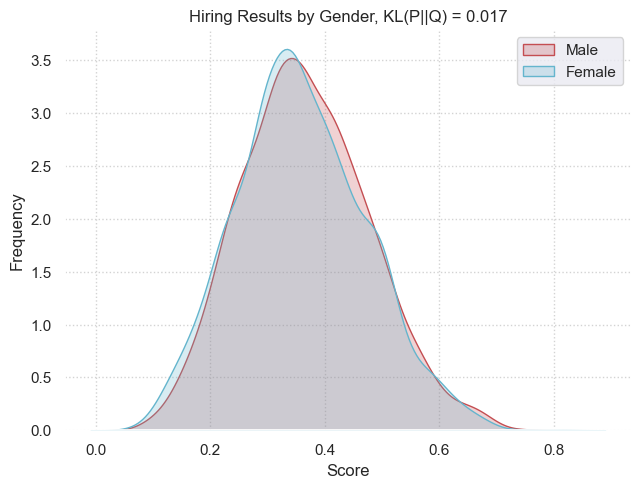

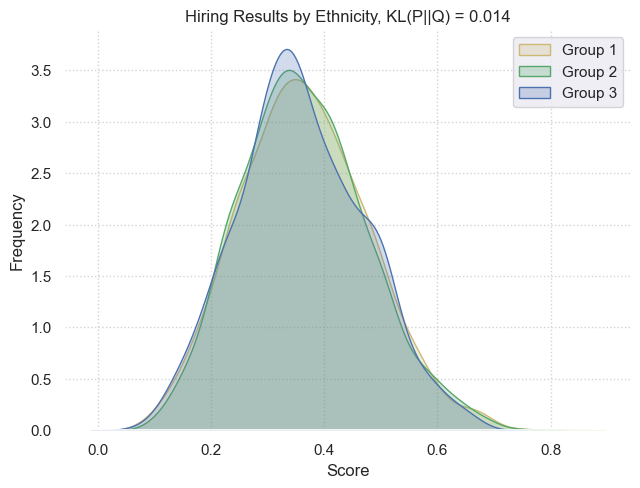

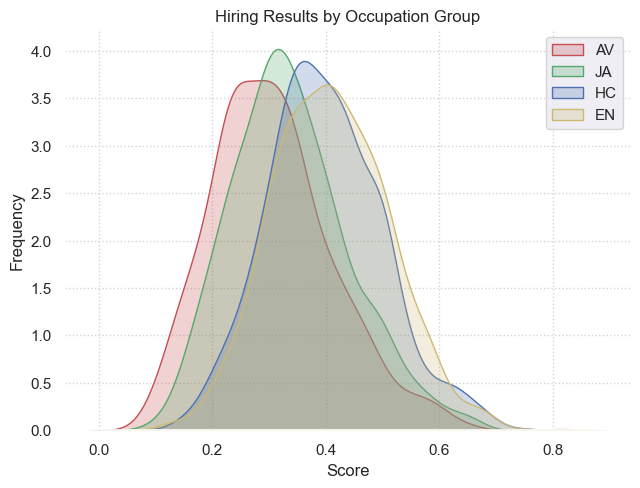

Computing Bias Metrics for configuration: agnostic gender


Top 100 Male: 52.40%
Top 100 Female: 47.60%
P-% Value: 90.84%
TPR Male: 49.11%
TPR Female: 45.55%
TPR Difference: 3.56%




In [104]:
# Run the model for agnostic gender

fairCVtestSensitive(data_path, database_file, word_emb_file, 'agnostic gender')

## Summary of Results from Model Training and Testing with Agnostic Gender Config

### Training and Evaluation Metrics

- **Model Summary**: The model uses an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features. It was trained over *16* epochs on about *6,089,769* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *0.046*, and the test loss (MAE) is *0.054*. The model performs slightly worse on the test set than on the training set but still maintains a relatively low error.

#### Bias Metrics

1. **Top Score**:
   - **Top 100 Male:** *52.40%*
   - **Top 100 Female:** *47.60%*
   - **Observation:** The model shows an almost balanced distribution of top scores between male and female candidates, meaning the bias against females has reduced drastically.


2. **Demographic Parity**:
   - **P-% Value:** *90.84%*
   - **Observation:** The P-% value is quite high, indicating a negligible bias towards either gender in the hiring process.


3. **True Positive Rate (TPR) Differences**:
   - **TPR Male:** *49.11%*
   - **TPR Female:** *45.55%*
   - **TPR Difference:** *3.56%*
   - **Observation:** There is a small difference in TPR between male and female candidates, but it's fairly low so it's acceptable


### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.017*
The plot shows the distribution of hiring scores by gender using a dist plot. A KL divergence of *0.017* indicates essentially no variance between male and female score distributions, so there's no bias in hiring results.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.014*
The plot shows the distribution of hiring scores by ethnicity using a dist plot. A KL divergence of *0.014* indicates very little variance between different ethnic groups, which is expected as ethnicity labels are not considered in the "agnostic gender" config.

#### 3. Hiring Results by Occupation Group
This plot shows the distribution of hiring scores across four different occupation groups using dist plots. There are slight variations in the distributions, indicating some influence of job categories on hiring results.

### Comparison of Default Model (gender config) and Sensitive Model (agnostic gender config)

| Metric               |    Default Model    |    SensitiveNets Model    |
|:---------------------|:-------------------:|:-------------------------:|
| Top 100 Male (%)     | *71.40*             | *52.40*                   |
| Top 100 Female (%)   | *28.60*             | *47.60*                   |
| P-% Value (%)        | *40.06*             | *90.84*                   |
| TPR Male (%)         | *79.26*             | *49.11*                   |
| TPR Female (%)       | *29.14*             | *45.55*                   |
| TPR Difference (%)   | *50.11*             | *3.56*                    |


### Conclusion

The model shows almost no bias towards any specific gender when trained with agnostic gender configuration, indicating a fair hiring process, which is in stark contrast with the results we got when we trained the hiring tool on the gender config which used gender-biased labels. Thus, the hiring tool's bias has been successfully mitigated among the genders.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 154)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 154, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           85248       embedding[0][0]                  
______________________________________________________________________________________________

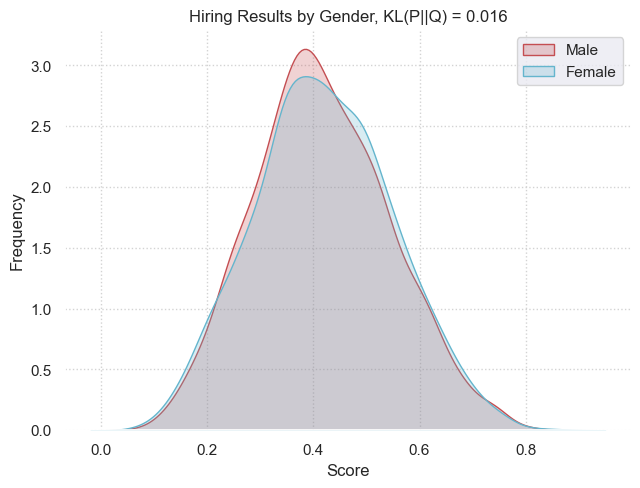

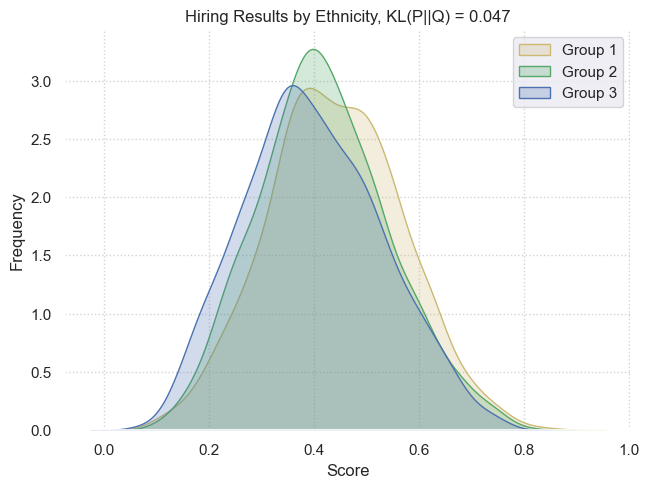

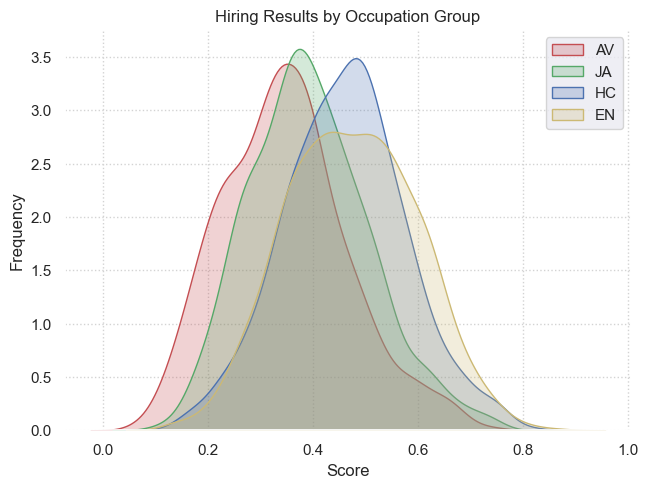

Computing Bias Metrics for configuration: agnostic ethnicity


Top 100 G1: 41.40%
Top 100 G2: 30.50%
Top 100 G3: 28.10%
P-% Value (G2/G1): 73.67%
P-% Value (G3/G1): 67.87%
P-% Value (G3/G2): 92.13%
TPR G1: 84.90%
TPR G2: 80.72%
TPR G3: 77.84%
TPR Difference(G1-G2): 4.18%
TPR Difference(G1-G3): 7.06%
TPR Difference(G2-G3): 2.88%




In [105]:
# Run the model for agnostic ethnicity

fairCVtestSensitive(data_path, database_file, word_emb_file, 'agnostic ethnicity')

## Summary of Results from Model Training and Testing with Agnostic Ethnicity Config

### Training and Evaluation Metrics

- **Model Summary**: The model uses an embedding layer, a bidirectional LSTM for text input (bios), and dense layers for profile features. It was trained over *16* epochs on about *90,000* parameters.

- **Training and Evaluation Loss (MAE)**: The training loss (MAE) is *0.060*, and the test loss (MAE) is *0.070*. The model performs almost equally on both the training and test sets with a low error.

#### Bias Metrics

1. **Top Score**:
   - **Top 100 G1:** *41.40%*
   - **Top 100 G2:** *30.50%*
   - **Top 100 G3:** *28.10%*
   - **Observation:** Although there's minor bias towards G1, the bias overall has been reduced significantly


2. **Demographic Parity**:
   - **P-% Value (G2/G1):** *73.67%*
   - **P-% Value (G3/G1):** *67.87%*
   - **P-% Value (G3/G2):** *92.13%*
   - **Observation:** Again, while G1 is favoured more, the bias has been mitigated quite well.


3. **True Positive Rate (TPR) Differences**:
   - **TPR G1:** *84.90%*
   - **TPR G2:** *80.72%*
   - **TPR G3:** *77.84%*
   - **TPR Difference (G1-G2):** *4.18%*
   - **TPR Difference (G1-G3):** *7.06%*
   - **TPR Difference (G2-G3):** *2.88%*
   - **Observation**: While the rate of correct predictions seem to be higher for G1, the differences between the groups is less than 10% which is not the best but it's not a significant difference so the bias has been reduced overall.

### Plots

#### 1. Hiring Results by Gender, KL(P||Q) = *0.016*
The plot shows the distribution of hiring scores by gender using a dist plot. A KL divergence of *0.014* indicates minimal variance between male and female score distributions, showing little to no gender bias in hiring results, which is expected as we're using gender-blind labels.

#### 2. Hiring Results by Ethnicity, KL(P||Q) = *0.047*
The plot shows the distribution of hiring scores by ethnicity using a dist plot. A KL divergence of *0.042* is very low. Thus, there isn't any noticeable variance between the groups, showing that ethnicity bias in hiring results has been reduced greatly with agnostic labels.

#### 3. Hiring Results by Occupation Group
This plot shows the distribution of hiring scores across four different occupation groups using dist plots. There are slight variations in the distributions, indicating some influence of job categories on hiring results.

### Comparison of Default Model (ethnicity config) and Sensitive Model (agnostic ethnicity config)

| Metric                      |    Default Model    |    SensitiveNets Model    |
|:----------------------------|:-------------------:|:-------------------------:|
| Top 100 G1 (%)              | *52.50*             | *41.40*                   |
| Top 100 G2 (%)              | *27.20*             | *30.50*                   |
| Top 100 G3 (%)              | *20.30*             | *28.10*                   |
| P-% Value (G2/G1) (%)       | *51.81*             | *73.67*                   |
| P-% Value (G3/G1) (%)       | *38.67*             | *67.87*                   |
| P-% Value (G3/G2) (%)       | *74.63*             | *92.13*                   |
| TPR G1 (%)                  | *90.59*             | *84.90*                   |
| TPR G2 (%)                  | *78.24*             | *80.72*                   |
| TPR G3 (%)                  | *59.46*             | *77.84*                   |
| TPR Difference (G1-G2) (%)  | *12.36*             | *4.18*                    |
| TPR Difference (G1-G3) (%)  | *31.13*             | *7.06*                    |
| TPR Difference (G2-G3) (%)  | *18.78*             | *2.88*                    |


### Conclusion

The model still shows slight bias towards Group 1 but the overall bias against Groups 2 and 3 have been reduced greatly when trained with agnostic ethnicity configuration, indicating a fair hiring process, which is in stark contrast with the results we got when we trained the hiring tool on the ethnicity config which used ethnicity-biased labels. Thus, the hiring tool's bias has been successfully mitigated among the ethnicities with some minor compromise.

## Hybrid Model Creation (RF + NN)

In [47]:
def trainRandomForest(embeddings_train, labels_train):
    rf_clf = RandomForestClassifier(max_depth=1000, random_state=0)
    rf_clf.fit(embeddings_train, labels_train)
    return rf_clf

In [48]:
def getRFPredictions(rf_clf, embeddings):
    rf_predictions = rf_clf.predict_proba(embeddings)[:, 1]  # Assuming binary classification
    return rf_predictions

In [49]:
def evaluateHybridNeuralNetwork(embeddings_train, embeddings_test, rf_train_predictions, rf_test_predictions, labels_train, labels_test):
    labels_train = keras.utils.to_categorical(labels_train)
    labels_test = keras.utils.to_categorical(labels_test)
    
    # Define neural network
    embedding_input = Input(shape=(embeddings_train.shape[1],))
    rf_input = Input(shape=(1,))  # Input for RF predictions
    
    x = Dense(128, activation='relu', name='embedding_layer')(embedding_input)
    x = Dropout(0.3)(x)
    x = Concatenate()([x, rf_input])
    x = Dense(64, activation='relu')(x)
    x = Dense(labels_train.shape[1], activation='softmax')(x)
        
    hybrid_nn_clf = keras.Model(inputs=[embedding_input, rf_input], outputs=x)

    hybrid_nn_clf.compile(optimizer=keras.optimizers.Adam(),
                          loss=keras.losses.CategoricalCrossentropy(), metrics=['acc'])
        
    # Train and evaluate network
    callback = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
    
    hybrid_nn_clf.fit([embeddings_train, rf_train_predictions], labels_train, batch_size=BATCH_SIZE,
                      epochs=NUM_EPOCHS_DEMO, callbacks=[callback],
                      validation_data=([embeddings_test, rf_test_predictions], labels_test))
    
    y_pred_nn = hybrid_nn_clf.predict([embeddings_test, rf_test_predictions])
    y_pred_nn_prob = y_pred_nn[:, 1]
    
    # Generate embeddings
    embedding_layer_output = hybrid_nn_clf.get_layer('embedding_layer').output
    feature_extractor = keras.Model(inputs=[embedding_input, rf_input], outputs=embedding_layer_output)
    
    final_embeddings = feature_extractor.predict([embeddings_test, rf_test_predictions])
    final_embeddings = preprocessing.normalize(final_embeddings, norm='l2', axis=1, copy=True, return_norm=False)
    
    return hybrid_nn_clf, final_embeddings, y_pred_nn_prob

In [50]:
def hybridModel(data_path, database_file, config):
    keras.backend.clear_session()
    os.chdir(data_path)
    
    labels_train, labels_test, profiles_train, profiles_test, bios_train, bios_test = loadAgnosticDataset(data_path, database_file, config)
    demo_labels_train = labels_train[:, 1]
    demo_labels_test = labels_test[:, 1]
    
    tokenizer_file = 'Tokenizer ' + config + '.pickle'
    with open(tokenizer_file, 'rb') as f:
        t = pickle.load(f)
    
    results_file = 'FairCVtest ' + config + '.npy'
    results = np.load(results_file, allow_pickle=True).item()
    max_len = results['Len Bios']
    
    bios_train, _, _ = processBios(bios_train, t, max_len)
    bios_test, _, _ = processBios(bios_test, t, max_len)
    
    embeddings_train, embeddings_test = generateCVEmbeddings(config, profiles_train, profiles_test, bios_train, bios_test)
    
    # Train Random Forest
    rf_clf = trainRandomForest(embeddings_train, demo_labels_train)
    rf_train_predictions = getRFPredictions(rf_clf, embeddings_train)
    rf_test_predictions = getRFPredictions(rf_clf, embeddings_test)
    
    # Evaluate Hybrid Neural Network
    hybrid_nn_clf, final_embeddings, nn_test_predictions = evaluateHybridNeuralNetwork(
        embeddings_train, embeddings_test, rf_train_predictions, rf_test_predictions,
        demo_labels_train, demo_labels_test)
    
    # t-SNE representation
    representTSNE(data_path, final_embeddings, demo_labels_test, config)

Epoch 1/100
150/150 [==============================] - 1s 3ms/step - loss: 0.4518 - acc: 0.9066 - val_loss: 0.7131 - val_acc: 0.5238
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 0.1268 - acc: 0.9992 - val_loss: 0.7875 - val_acc: 0.5256
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0391 - acc: 0.9993 - val_loss: 0.8517 - val_acc: 0.5265
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0184 - acc: 0.9994 - val_loss: 0.9106 - val_acc: 0.5256
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0111 - acc: 0.9994 - val_loss: 0.9570 - val_acc: 0.5254
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0075 - acc: 0.9994 - val_loss: 0.9875 - val_acc: 0.5260
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0058 - acc: 0.9993 - val_loss: 1.0380 - val_acc: 0.5250
Epoch 8/100
150/150 [==============================] - 0s 3ms/step - 

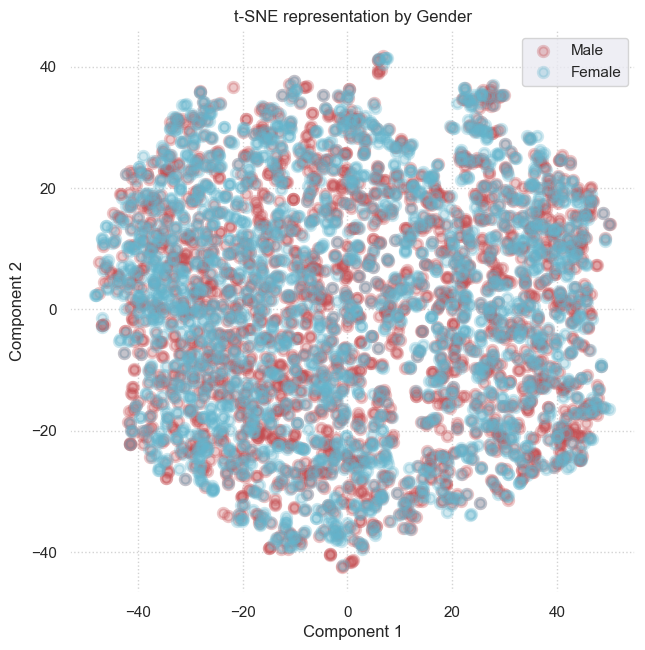

In [106]:
# Run the hybrid model pipeline for agnostic gender config
hybridModel(data_path, database_file, 'agnostic gender')

## Summary of Results from Hybrid Model Training and Testing with Agnostic Gender Config

A Random Forest model is trained on the embeddings from the hiring tool. A Neural Network which is also trained on embeddings from the hiring tool. The random forest model's predictions and probabalities are concatenated and passed through the subsequent layers of the Neural Network, thus combining the interpretability of decision trees with the predictive capabilities of the neural network.

### t-SNE Representation by Gender

The plot utilizes t-SNE to display the embeddings with colors representing genders. The t-SNE plot reveals a fair mix of male and female candidates, within the embedding space, thus the neural network trained on the sensitive model is fair.

### Conclusion

As we can see from the t-SNE plot produced with embeddings generated from the Hybrid Neural Network, the bias among the male and female candidates has been successfully mitigated so the hybrid model is successful.

Epoch 1/100
150/150 [==============================] - 1s 3ms/step - loss: 0.8276 - acc: 0.6868 - val_loss: 1.0078 - val_acc: 0.5063
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 0.5189 - acc: 0.7963 - val_loss: 1.0509 - val_acc: 0.4994
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 0.4278 - acc: 0.8016 - val_loss: 1.1001 - val_acc: 0.4963
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 0.4046 - acc: 0.8020 - val_loss: 1.1479 - val_acc: 0.4942
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: 0.3943 - acc: 0.8028 - val_loss: 1.1828 - val_acc: 0.4946
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 0.3888 - acc: 0.8053 - val_loss: 1.2270 - val_acc: 0.4913
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: 0.3855 - acc: 0.8050 - val_loss: 1.2456 - val_acc: 0.4944
Epoch 8/100
150/150 [==============================] - 0s 3ms/step - 

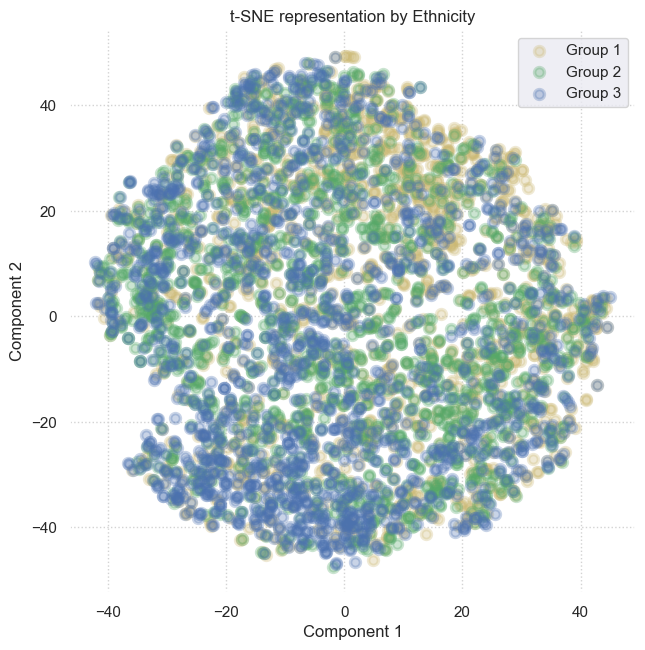

In [107]:
# Run the hybrid model pipeline for agnostic ethnicity config
hybridModel(data_path, database_file, 'agnostic ethnicity')

## Summary of Results from Hybrid Model Training and Testing with Agnostic Ethnicity Config

A Random Forest model is trained on the embeddings from the hiring tool. A Neural Network which is also trained on embeddings from the hiring tool. The random forest model's predictions and probabalities are concatenated and passed through the subsequent layers of the Neural Network, thus combining the interpretability of decision trees with the predictive capabilities of the neural network.

### t-SNE Representation by Ethnicity

The t-SNE plot shows embeddings of candidate profiles in 2-D with colors representing ethnicity. There is no noticeable separation between the different ethnic groups, indicating that ethnicity bias has been reduced greatly.

### Conclusion

As we can see from the t-SNE plot produced with embeddings generated from the Hybrid Neural Network, the bias among the different ethnicities has been successfully mitigated so the hybrid model is successful.

# Limitations of the Project

**1. Threshold for Adversarial Debiasing:** The adversarial debiasing approach involves using a certain threshold of loss weights that can be used to penalise the model for using sensitive attributes in its predictions. However, this particular threshold is not constant, and requires numerous attempts of trial and error to find the optimal value. This process is inefficient and time-consuming.

**2. Model Performance vs. Bias Mitigation:** There is often a trade-off between model performance and bias mitigation. As seen in the results, increasing the adversarial loss weight to reduce bias can lead to poor model performance. This is particularly evident in the adversarial models where attempts to eliminate bias resulted in very high loss values and poor predictive performance. This is also true for the SensitiveNets model which mitigated the gender bias but diminished the model performance for males, instead of increasing it for females. The same is true for the hybrid model as well. 

# Future Work

**1. Automate Hyperparameter Tuning:** Implement automated hyperparameter tuning for the adversarial loss weight to optimize the balance between performance and bias mitigation efficiently.

**2. Intersectional Analysis:** Perform intersectional analysis by considering multiple sensitive attributes simultaneously to understand and mitigate more complex forms of bias.

**3. Interpretability Tools:** Integrate interpretability tools such as SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to make the hybrid model more interpretable and explainable.

Note: Please make a copy of this notebook before running it. Results may vary slightly if you choose to run it again.